## Imports and utility functions


In [1]:


import numpy as np
import os
os.system('source /home/jackalak/heartbeat/cdf38_0-dist/bin/definitions.B')
os.environ["CDF_LIB"] = '/home/jackalak/heartbeat/cdf38_0-dist/lib'
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold

from pickle import dump
import joblib

# from keras import backend as K
import tensorflow.keras as k
from tensorflow.keras import utils, models, layers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf

from scipy.stats import gaussian_kde

from ovationpyme import ovation_prime
from ovationpyme import ovation_utilities

#from nasaomnireader import omnireader
from geospacepy import omnireader, special_datetime

#import time_hist2

#import netCDF4



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nasaomnireader-0.1.0-py3.6.egg/nasaomnireader/__init__.py", line 5, in <module>
    from nasaomnireader.omnireader_config import config
ModuleNotFoundError: No module named 'nasaomnireader.omnireader_config'

Solar wind data files will be saved to /home/jackalak/.local/share/nasaomnireader


In [2]:
print(k.__version__)
print(tf.__version__)


2.4.0
2.3.1


In [3]:

def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))


def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
#     print('working on {} outlier detection and removal'.format(str_id))
#     print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
#     print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df

# Metrics defined by 2019 GNSS FDL team
def dynamic_range_and_mae_loss(y_true, y_pred):
    mae = k.losses.mean_absolute_error(y_true, y_pred)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = k.backend.abs(dynamic_range_true - dynamic_range_pred)
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae + 0.1* dynamic_range_loss

def different_exponent(y_true, y_pred):
    # |x-y|^3 with dynamic range
    mae = k.backend.pow(k.backend.abs(y_true-y_pred),3)
    mae = k.backend.mean(mae)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae+ 0.1* dynamic_range_loss

def tilted_loss(q,y_true,y_pred):
    e = (y_true-y_pred)
    return k.backend.mean(k.backend.maximum(q*e, (q-1)*e), axis=-1)

# def plot_box_summary(df,save_location,save_filename):
# NOTE: now use %run box_plot_summary_function.ipynb for this functionality

In [4]:
%run standard_assessment_metrics_function.ipynb

In [5]:
DMSP_FIGURE_DIR = 'DMSPdata/figures/'
DMSP_DATA_DIR = 'DMSPdata/data/'
POLAR_VIS_DATA_DIR = 'POLAR_VISdata/POLAR_VIS_Jan_25_2000/'


In [6]:
eflux_threshold_quantile = 99.995
eflux_threshold = .99995

erg_eV_factor = (1.60218e-12)

## Prepare data for ML exploration (read in full DB created from standard_ML_DB_preparation.ipynb)


In [7]:
# file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
file_load_df_cumulative = '/home/jackalak/heartbeat/ParticlePrecipitation/ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv' #ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine_PCfixed.csv'
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)



In [8]:
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AE',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'vx',
 'psw',
 'borovsky',
 'newell',
 'F107_6hr',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'vx_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'F107_5hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'AL_5hr',
 'AU_5hr',
 'SymH_5hr',
 'PC_5hr',
 'vsw_5hr',
 'vx_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'F107_3hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'vx_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'F107_1hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'vx_1hr',
 'psw_1hr',
 '

In [9]:
df_cumulative_no_cols_dropped = df_cumulative.copy()

In [10]:

# df_cumulative_LTIMEs = df_cumulative_no_cols_dropped['SC_AACGM_LTIME'].copy(deep=True)
# df_cumulative_STDs = df_cumulative_no_cols_dropped['ELE_TOTAL_ENERGY_FLUX_STD'].copy(deep=True)
df_cumulative_LTIMEs = df_cumulative['SC_AACGM_LTIME'].copy(deep=True)
df_cumulative_STDs = df_cumulative['ELE_TOTAL_ENERGY_FLUX_STD'].copy(deep=True)

# cols_to_drop = [c for c in df_cumulative.columns if ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative_no_cols_dropped.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c)| ('5hr' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = []

# Final selected set: RMM July 16, 2020
cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]


# df_cumulative = df_cumulative_no_cols_dropped.drop(columns=cols_to_drop)
df_cumulative = df_cumulative.drop(columns=cols_to_drop)


In [11]:
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [12]:
print('number of input features total = {}'.format(df_cumulative.shape[1]))

number of input features total = 73


In [13]:
# Remove outliers
# idx_outliers = np.where( df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],99.995) )

print(df_cumulative.shape)
threshold_drop_val = np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],eflux_threshold_quantile)
# print('... dropping rows where total electron energy flux is greater than {:.4E} [eV/cm2/s/ster]'.format(threshold_drop_val))
# print('--------> number dropped = {}'.format(len( np.argwhere(df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > threshold_drop_val) )))
df_cumulative_LTIMEs = df_cumulative_LTIMEs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
df_cumulative_STDs = df_cumulative_STDs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
df_cumulative = df_cumulative[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
print(df_cumulative.shape)

# np.where(df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],99.995))





(1947016, 73)
(1946918, 73)


In [14]:
print( 'number of input features = {}'.format( len(df_cumulative.columns.to_list()) ) )

df_cumulative.columns.to_list()

number of input features = 73


['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [15]:
# Separate training and testing data
# mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
mask_val = [ ((df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)) | 
             ((df_cumulative.index.year == 2000) & (df_cumulative.index.month == 1) & (df_cumulative.index.day == 25)) ]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we will use CV on the train data below to define model training and testing data,\n  so have called the withheld data *validation* data here')

# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]


X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
# scaler_X = preprocessing.MinMaxScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()

validation data shape = (55210, 73)
train data shape = (1838185, 73)
NOTE: we will use CV on the train data below to define model training and testing data,
  so have called the withheld data *validation* data here


In [16]:
y_train = y_train * np.pi
y_val = y_val * np.pi
print('NOTE: removing the steradian from the DMSP data BEFORE training/n/n    ----> RMM May 28, 2020')

y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)


y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

NOTE: removing the steradian from the DMSP data BEFORE training/n/n    ----> RMM May 28, 2020


In [17]:
# Read in OVATION Prime model data at DMSP validation data locations 
#      (created by RMM using 'OVATIONprime_atDMSPvalidationData.py' on 
#       May 22-24, 2020 using deepsun computing)
y_val_ovation = pd.read_csv(os.path.join(DMSP_DATA_DIR,'OVATIONprime_atDMSP_F16_2010_locations.csv'))
y_val_ovation = y_val_ovation.rename(columns={'Unnamed: 0':'Datetimes'})
y_val_ovation = y_val_ovation.set_index('Datetimes')
y_val_ovation.index = pd.to_datetime(y_val_ovation.index)


In [18]:
print('number of zero validation data points in OVATION = {}'.format(len(y_val_ovation['model value'][y_val_ovation['model value'] == 0.])))
      
      

number of zero validation data points in OVATION = 10893


In [19]:
y_val_ovation['model value'][y_val_ovation['model value'] == 0.] = 0.0001
y_val_ovation['model value log10(ev/cm2/s)'] = np.log10( y_val_ovation['model value']/(1.60218e-12) )

y_val_ovation = y_val_ovation.reindex(y_val_log.index)


## Interrogate the model

### Pre-step: Set constants and model construction

In [22]:
random_seed = 7

# mlepochs = 35
# batch_size = 400
# Dropout = 0.2
# learning_rate = 0.005

# JZ optimal model #3
mlepochs = 1000
batch_size = 32768
Dropout = 0.1
learning_rate = 0.001


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    Working on CV fold = 0
    ----> Indices
      1987-01-12 12:57:00
      2010-12-15 05:54:00
    Working on CV fold = 1
    ----> Indices
      2001-09-20 22:13:00
      2011-05-23 01:41:00
    Working on CV fold = 2
    ----> Indices
      2001-12-01 04:24:00
      2011-06-26 14:09:00
    Working on CV fold = 3
    ----> Indices
      2002-03-29 20:14:00
      2012-02-03 12:33:00
    Working on CV fold = 4
    ----> Indices
      2003-10-23 03:39:00
      2012-12-21 00:38:00
    Working on CV fold = 5
    ----> Indices
      2004-07-12 14:00:00
      2013-01-28 19:12:00
    Working on CV fold = 6
    ----> Indices
      2005-11-11 21:44:00
      2013-11-21 06:35:00
    Working on CV fold = 7
    ----> Indices
      2005-11-14 04:15:00
      2013-09-27 14:08:00
    Working on CV fold = 8
    ----> Indices
      2006-01-09 01:41:00
      2014-09-28 21:33:00
    Working on CV fold = 9
    ----> Indices
      2007-06-27 07:11:00
      2014-12-31 22:54:00


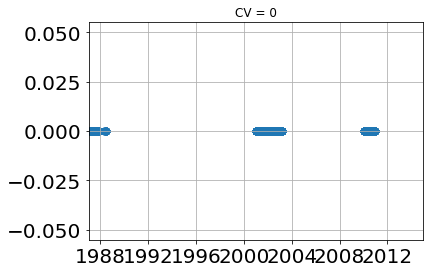

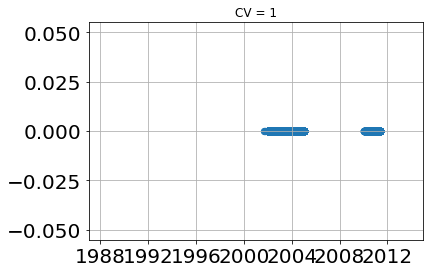

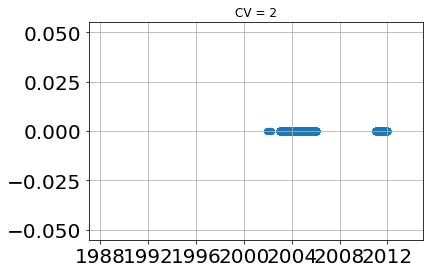

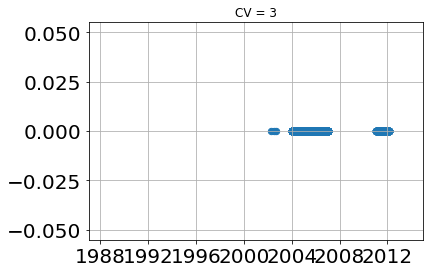

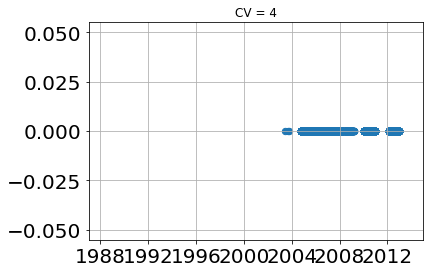

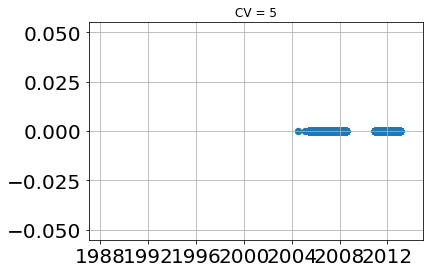

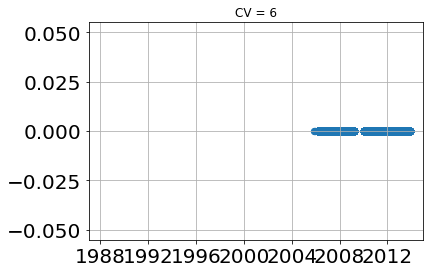

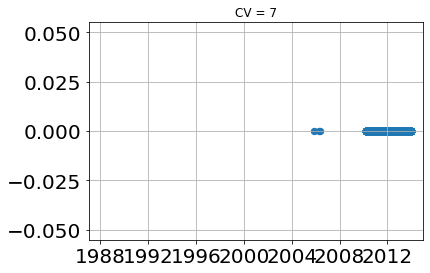

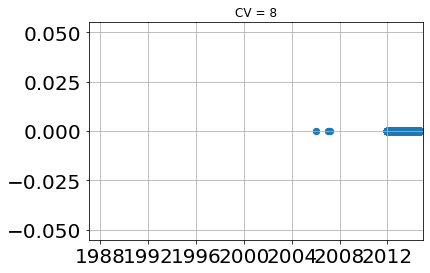

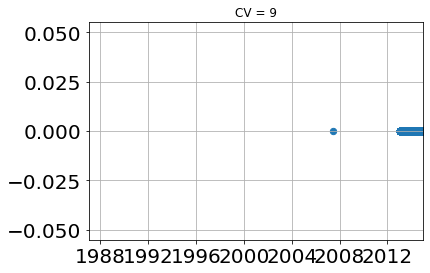

In [23]:
# Visualizing the stratified data samples

from sklearn.model_selection import StratifiedKFold
n_splits = 10
bins = np.linspace(0, 15, 15)
y_train_binned = np.digitize(y_train_log,
                             bins)

iteration = 0
skf = StratifiedKFold(n_splits=n_splits,shuffle=False, random_state=random_seed)
for train_index, test_index in skf.split(X_train.values, y_train_binned):
    print('    Working on CV fold = {}'.format(iteration))

    print('    ----> Indices\n      {}\n      {}'.format(y_train_log.index[test_index[0]],y_train_log.index[test_index[-1]]))
    print('===================')
#     plt.figure()
#     plt.hist(y_train_log[train_index].values)
#     plt.title('CV = '+str(iteration))

    plt.figure()
    plt.scatter(X_train.index[test_index],
                np.zeros(len(test_index)),
                s=40)
    plt.title('CV = '+str(iteration))
    plt.grid(True)
    plt.xlim(X_train.index[0],X_train.index[-1])
    iteration += 1

### Fit and compare cross-fold models 

In [24]:
# Create digitized y for stratified k-fold
from sklearn.model_selection import StratifiedKFold
n_splits = 10
bins = np.linspace(0, 15, 15)
y_train_binned = np.digitize(y_train_log,
                             bins)

df_CV_columns = ['CV'+str(x) for x in range(n_splits)]
df_CV = pd.DataFrame(columns=df_CV_columns,index=y_val_log.index)

df_metrics_CV_columns = ['iteration','MAE','MSE','RMSE','RAE','RSE','RSQ','linear slope','linear intercept']
df_metrics_CV_test = pd.DataFrame(columns=df_metrics_CV_columns,index=np.arange(n_splits))
df_metrics_CV_val = pd.DataFrame(columns=df_metrics_CV_columns,index=np.arange(n_splits))


# CREATE CROSS-VALIDATION SPLITS
iteration = 0
skf = StratifiedKFold(n_splits=n_splits,shuffle=False, random_state=random_seed)
for train_index, test_index in skf.split(X_train.values, y_train_binned):
    print('    Working on CV fold = {}'.format(iteration))

    
    # CREATE THE MODEL
#     model = k.models.Sequential()
#     model.add(k.layers.Dense(128, input_dim=X_train_scaled.shape[1], activation='selu'))
#     model.add(k.layers.AlphaDropout(Dropout))
#     model.add(k.layers.Dense(16, activation='selu'))
#     model.add(k.layers.Dense(4, activation='selu'))    
#     model.add(k.layers.Dense(1, activation='linear'))

    # JZ optimal model #3
    model = k.models.Sequential()
    model.add(k.layers.Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(k.layers.Dropout(Dropout))
    model.add(k.layers.Dense(64, activation='relu'))
    model.add(k.layers.Dense(32,activation='relu'))
    model.add(k.layers.Dense(256,activation='relu'))
    model.add(k.layers.Dense(1024,activation='relu'))
    model.add(k.layers.Dense(256, activation='relu'))
    model.add(k.layers.Dense(32, activation='relu'))
    model.add(k.layers.Dense(4, activation='relu'))    
    model.add(k.layers.Dense(1, activation='linear'))
    
    # FIT THE MODEL
    model.compile(loss='mse',
                  optimizer = k.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['logcosh','mse','mae'])
    history = model.fit(X_train_scaled[train_index],
                        y_train_log[train_index].values, 
                        epochs=mlepochs, 
                        batch_size=batch_size,
                        validation_data=(X_train_scaled[test_index], y_train_log[test_index].values), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  restore_best_weights=True,
             patience=100)])

    # PREDICT ON THE TEST AND VALIDATION DATA
    y_predict_test = model.predict(X_train_scaled[test_index])
    y_predict_val = model.predict(X_val_scaled)
    
    df_CV.iloc[:,iteration] = y_predict_val

    # CALCULATE METRICS
    MAE_test, MSE_test, RMSE_test, RAE_test, RSE_test, RSQ_test, lin_slope_test, lin_intercept_test = model_eval(y_train_log[test_index].values,y_predict_test)
    MAE_val, MSE_val, RMSE_val, RAE_val, RSE_val, RSQ_val, lin_slope_val, lin_intercept_val = model_eval(y_val_log.values,y_predict_val)

    # SAVE METRICS TO DATAFRAMES
    df_metrics_CV_test.iloc[iteration,:] = [iteration, MAE_test, MSE_test, RMSE_test, RAE_test, RSE_test, RSQ_test, lin_slope_test, lin_intercept_test]
    df_metrics_CV_val.iloc[iteration,:] = [iteration, MAE_val, MSE_val, RMSE_val, RAE_val, RSE_val, RSQ_val, lin_slope_val, lin_intercept_val]

    iteration += 1
        
        
# df_metrics_CV_test.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_testMetrics.csv'))
# df_metrics_CV_val.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_validationMetrics.csv'))
# df_CV.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_validationPredictions.csv'))
df_metrics_CV_test.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_testMetrics.csv'))
df_metrics_CV_val.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_validationMetrics.csv'))
df_CV.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_validationPredictions.csv'))
    
        
        
        

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    Working on CV fold = 0
Epoch 1/1000
51/51 [==============================] - 1s 24ms/step - loss: 93.4453 - logcosh: 8.8981 - mse: 93.4453 - mae: 9.5913 - val_loss: 94.1245 - val_logcosh: 8.9393 - val_mse: 94.1245 - val_mae: 9.6324
Epoch 2/1000
51/51 [==============================] - 1s 22ms/step - loss: 92.4617 - logcosh: 8.8467 - mse: 92.4617 - mae: 9.5399 - val_loss: 93.1475 - val_logcosh: 8.8884 - val_mse: 93.1475 - val_mae: 9.5816
Epoch 3/1000
51/51 [==============================] - 1s 22ms/step - loss: 91.4954 - logcosh: 8.7959 - mse: 91.4954 - mae: 9.4891 - val_loss: 92.1782 - val_logcosh: 8.8377 - val_mse: 92.1782 - val_mae: 9.5308
Epoch 4/1000
51/51 [==============================] - 1s 22ms/step - loss: 90.5366 - logcosh: 8.7453 - mse: 90.5366 - mae: 9.4384 - val_loss: 91.2164 - val_logcosh: 8.7871 - val_mse: 91.2164 - val_mae: 9.4803
Epoch 5/1000
51/51 [==============================] - 1s 22ms/step - loss: 89.5854 - logcosh: 8.6948 - mse: 89.5854 - mae: 9.3879 - val_l

Epoch 40/1000
51/51 [==============================] - 1s 22ms/step - loss: 60.5502 - logcosh: 6.9944 - mse: 60.5502 - mae: 7.6875 - val_loss: 61.1121 - val_logcosh: 7.0380 - val_mse: 61.1121 - val_mae: 7.7312
Epoch 41/1000
51/51 [==============================] - 1s 22ms/step - loss: 59.8303 - logcosh: 6.9474 - mse: 59.8303 - mae: 7.6405 - val_loss: 60.3887 - val_logcosh: 6.9911 - val_mse: 60.3887 - val_mae: 7.6842
Epoch 42/1000
51/51 [==============================] - 1s 22ms/step - loss: 59.1160 - logcosh: 6.9005 - mse: 59.1160 - mae: 7.5937 - val_loss: 59.6709 - val_logcosh: 6.9442 - val_mse: 59.6709 - val_mae: 7.6374
Epoch 43/1000
51/51 [==============================] - 1s 22ms/step - loss: 58.4072 - logcosh: 6.8537 - mse: 58.4072 - mae: 7.5468 - val_loss: 58.9586 - val_logcosh: 6.8975 - val_mse: 58.9586 - val_mae: 7.5906
Epoch 44/1000
51/51 [==============================] - 1s 22ms/step - loss: 57.7038 - logcosh: 6.8070 - mse: 57.7038 - mae: 7.5001 - val_loss: 58.2517 - val_log

51/51 [==============================] - 1s 22ms/step - loss: 36.3229 - logcosh: 5.2120 - mse: 36.3229 - mae: 5.9051 - val_loss: 36.7443 - val_logcosh: 5.2569 - val_mse: 36.7443 - val_mae: 5.9501
Epoch 80/1000
51/51 [==============================] - 1s 22ms/step - loss: 35.7994 - logcosh: 5.1675 - mse: 35.7994 - mae: 5.8606 - val_loss: 36.2172 - val_logcosh: 5.2125 - val_mse: 36.2172 - val_mae: 5.9056
Epoch 81/1000
51/51 [==============================] - 1s 22ms/step - loss: 35.2806 - logcosh: 5.1231 - mse: 35.2806 - mae: 5.8162 - val_loss: 35.6948 - val_logcosh: 5.1681 - val_mse: 35.6948 - val_mae: 5.8612
Epoch 82/1000
51/51 [==============================] - 1s 22ms/step - loss: 34.7663 - logcosh: 5.0787 - mse: 34.7663 - mae: 5.7718 - val_loss: 35.1769 - val_logcosh: 5.1237 - val_mse: 35.1769 - val_mae: 5.8168
Epoch 83/1000
51/51 [==============================] - 1s 22ms/step - loss: 34.2567 - logcosh: 5.0344 - mse: 34.2567 - mae: 5.7275 - val_loss: 34.6635 - val_logcosh: 5.0795 -

Epoch 118/1000
51/51 [==============================] - 1s 22ms/step - loss: 19.2143 - logcosh: 3.5226 - mse: 19.2143 - mae: 4.2145 - val_loss: 19.4946 - val_logcosh: 3.5686 - val_mse: 19.4946 - val_mae: 4.2607
Epoch 119/1000
51/51 [==============================] - 1s 22ms/step - loss: 18.8617 - logcosh: 3.4807 - mse: 18.8617 - mae: 4.1725 - val_loss: 19.1384 - val_logcosh: 3.5267 - val_mse: 19.1384 - val_mae: 4.2187
Epoch 120/1000
51/51 [==============================] - 1s 22ms/step - loss: 18.5133 - logcosh: 3.4388 - mse: 18.5133 - mae: 4.1305 - val_loss: 18.7865 - val_logcosh: 3.4849 - val_mse: 18.7865 - val_mae: 4.1768
Epoch 121/1000
51/51 [==============================] - 1s 22ms/step - loss: 18.1690 - logcosh: 3.3971 - mse: 18.1690 - mae: 4.0886 - val_loss: 18.4386 - val_logcosh: 3.4432 - val_mse: 18.4386 - val_mae: 4.1349
Epoch 122/1000
51/51 [==============================] - 1s 22ms/step - loss: 17.8288 - logcosh: 3.3554 - mse: 17.8288 - mae: 4.0468 - val_loss: 18.0948 - va

Epoch 157/1000
51/51 [==============================] - 1s 22ms/step - loss: 8.4202 - logcosh: 1.9740 - mse: 8.4202 - mae: 2.6397 - val_loss: 8.5654 - val_logcosh: 2.0186 - val_mse: 8.5654 - val_mae: 2.6878
Epoch 158/1000
51/51 [==============================] - 1s 22ms/step - loss: 8.2196 - logcosh: 1.9377 - mse: 8.2196 - mae: 2.6014 - val_loss: 8.3614 - val_logcosh: 1.9822 - val_mse: 8.3614 - val_mae: 2.6497
Epoch 159/1000
51/51 [==============================] - 1s 22ms/step - loss: 8.0226 - logcosh: 1.9018 - mse: 8.0226 - mae: 2.5633 - val_loss: 8.1611 - val_logcosh: 1.9460 - val_mse: 8.1611 - val_mae: 2.6117
Epoch 160/1000
51/51 [==============================] - 1s 22ms/step - loss: 7.8291 - logcosh: 1.8661 - mse: 7.8291 - mae: 2.5253 - val_loss: 7.9644 - val_logcosh: 1.9101 - val_mse: 7.9644 - val_mae: 2.5738
Epoch 161/1000
51/51 [==============================] - 1s 22ms/step - loss: 7.6393 - logcosh: 1.8307 - mse: 7.6393 - mae: 2.4875 - val_loss: 7.7712 - val_logcosh: 1.8744 -

51/51 [==============================] - 1s 23ms/step - loss: 3.0601 - logcosh: 0.8549 - mse: 3.0601 - mae: 1.3481 - val_loss: 3.0831 - val_logcosh: 0.8744 - val_mse: 3.0831 - val_mae: 1.3816
Epoch 197/1000
51/51 [==============================] - 1s 24ms/step - loss: 2.9824 - logcosh: 0.8367 - mse: 2.9824 - mae: 1.3247 - val_loss: 3.0026 - val_logcosh: 0.8550 - val_mse: 3.0026 - val_mae: 1.3574
Epoch 198/1000
51/51 [==============================] - 1s 24ms/step - loss: 2.9073 - logcosh: 0.8190 - mse: 2.9073 - mae: 1.3019 - val_loss: 2.9246 - val_logcosh: 0.8361 - val_mse: 2.9246 - val_mae: 1.3341
Epoch 199/1000
51/51 [==============================] - 1s 24ms/step - loss: 2.8347 - logcosh: 0.8020 - mse: 2.8347 - mae: 1.2798 - val_loss: 2.8492 - val_logcosh: 0.8179 - val_mse: 2.8492 - val_mae: 1.3115
Epoch 200/1000
51/51 [==============================] - 1s 23ms/step - loss: 2.7646 - logcosh: 0.7855 - mse: 2.7646 - mae: 1.2584 - val_loss: 2.7763 - val_logcosh: 0.8002 - val_mse: 2.776

Epoch 236/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.5390 - logcosh: 0.5239 - mse: 1.5390 - mae: 0.9741 - val_loss: 1.4666 - val_logcosh: 0.4967 - val_mse: 1.4666 - val_mae: 0.9161
Epoch 237/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.5300 - logcosh: 0.5228 - mse: 1.5300 - mae: 0.9753 - val_loss: 1.4559 - val_logcosh: 0.4949 - val_mse: 1.4559 - val_mae: 0.9153
Epoch 238/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.5217 - logcosh: 0.5219 - mse: 1.5217 - mae: 0.9767 - val_loss: 1.4460 - val_logcosh: 0.4933 - val_mse: 1.4460 - val_mae: 0.9148
Epoch 239/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.5142 - logcosh: 0.5212 - mse: 1.5142 - mae: 0.9782 - val_loss: 1.4369 - val_logcosh: 0.4918 - val_mse: 1.4369 - val_mae: 0.9146
Epoch 240/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.5073 - logcosh: 0.5206 - mse: 1.5073 - mae: 0.9797 - val_loss: 1.4285 - val_logcosh: 0.4905 -

51/51 [==============================] - 1s 22ms/step - loss: 1.4523 - logcosh: 0.5252 - mse: 1.4523 - mae: 1.0195 - val_loss: 1.3469 - val_logcosh: 0.4845 - val_mse: 1.3469 - val_mae: 0.9434
Epoch 276/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4523 - logcosh: 0.5253 - mse: 1.4523 - mae: 1.0197 - val_loss: 1.3467 - val_logcosh: 0.4845 - val_mse: 1.3467 - val_mae: 0.9436
Epoch 277/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4523 - logcosh: 0.5254 - mse: 1.4523 - mae: 1.0200 - val_loss: 1.3466 - val_logcosh: 0.4845 - val_mse: 1.3466 - val_mae: 0.9439
Epoch 278/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5254 - mse: 1.4522 - mae: 1.0202 - val_loss: 1.3465 - val_logcosh: 0.4846 - val_mse: 1.3465 - val_mae: 0.9440
Epoch 279/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5255 - mse: 1.4522 - mae: 1.0203 - val_loss: 1.3464 - val_logcosh: 0.4846 - val_mse: 1.346

Epoch 315/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 316/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 317/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 318/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 319/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3458 - val_logcosh: 0.4847 -

51/51 [==============================] - 1s 21ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 355/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3457 - val_logcosh: 0.4848 - val_mse: 1.3457 - val_mae: 0.9452
Epoch 356/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9450
Epoch 357/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 358/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.345

Epoch 394/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0215 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 395/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3459 - val_logcosh: 0.4847 - val_mse: 1.3459 - val_mae: 0.9450
Epoch 396/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 397/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9452
Epoch 398/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4522 - logcosh: 0.5260 - mse: 1.4522 - mae: 1.0216 - val_loss: 1.3457 - val_logcosh: 0.4847 -

51/51 [==============================] - 1s 23ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0212 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 434/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9452
Epoch 435/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3457 - val_logcosh: 0.4848 - val_mse: 1.3457 - val_mae: 0.9453
Epoch 436/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0215 - val_loss: 1.3460 - val_logcosh: 0.4847 - val_mse: 1.3460 - val_mae: 0.9448
Epoch 437/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3457 - val_logcosh: 0.4848 - val_mse: 1.345

Epoch 473/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 474/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3457 - val_logcosh: 0.4847 - val_mse: 1.3457 - val_mae: 0.9452
Epoch 475/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0212 - val_loss: 1.3456 - val_logcosh: 0.4848 - val_mse: 1.3456 - val_mae: 0.9454
Epoch 476/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9450
Epoch 477/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0215 - val_loss: 1.3456 - val_logcosh: 0.4848 -

51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 513/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0211 - val_loss: 1.3455 - val_logcosh: 0.4848 - val_mse: 1.3455 - val_mae: 0.9456
Epoch 514/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0215 - val_loss: 1.3458 - val_logcosh: 0.4847 - val_mse: 1.3458 - val_mae: 0.9451
Epoch 515/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0212 - val_loss: 1.3453 - val_logcosh: 0.4849 - val_mse: 1.3453 - val_mae: 0.9459
Epoch 516/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3456 - val_logcosh: 0.4848 - val_mse: 1.345

Epoch 552/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3460 - val_logcosh: 0.4847 - val_mse: 1.3460 - val_mae: 0.9448
Epoch 553/1000
51/51 [==============================] - 1s 25ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0214 - val_loss: 1.3461 - val_logcosh: 0.4847 - val_mse: 1.3461 - val_mae: 0.9447
Epoch 554/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4522 - logcosh: 0.5258 - mse: 1.4522 - mae: 1.0211 - val_loss: 1.3455 - val_logcosh: 0.4848 - val_mse: 1.3455 - val_mae: 0.9455
Epoch 555/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4522 - logcosh: 0.5260 - mse: 1.4522 - mae: 1.0217 - val_loss: 1.3459 - val_logcosh: 0.4847 - val_mse: 1.3459 - val_mae: 0.9450
Epoch 556/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4522 - logcosh: 0.5259 - mse: 1.4522 - mae: 1.0213 - val_loss: 1.3457 - val_logcosh: 0.4847 -

Epoch 9/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.7610 - logcosh: 0.2929 - mse: 0.7610 - mae: 0.6754 - val_loss: 0.7097 - val_logcosh: 0.2783 - val_mse: 0.7097 - val_mae: 0.6642
Epoch 10/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.7010 - logcosh: 0.2713 - mse: 0.7010 - mae: 0.6412 - val_loss: 0.6078 - val_logcosh: 0.2405 - val_mse: 0.6078 - val_mae: 0.6026
Epoch 11/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.6558 - logcosh: 0.2552 - mse: 0.6558 - mae: 0.6156 - val_loss: 0.5824 - val_logcosh: 0.2314 - val_mse: 0.5824 - val_mae: 0.5888
Epoch 12/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.6348 - logcosh: 0.2476 - mse: 0.6348 - mae: 0.6035 - val_loss: 0.5955 - val_logcosh: 0.2368 - val_mse: 0.5955 - val_mae: 0.5995
Epoch 13/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.6156 - logcosh: 0.2407 - mse: 0.6156 - mae: 0.5921 - val_loss: 0.5697 - val_logcosh: 0.2240 - val_m

Epoch 49/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4896 - logcosh: 0.1950 - mse: 0.4896 - mae: 0.5151 - val_loss: 0.4645 - val_logcosh: 0.1866 - val_mse: 0.4645 - val_mae: 0.5072
Epoch 50/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4828 - logcosh: 0.1925 - mse: 0.4828 - mae: 0.5104 - val_loss: 0.4633 - val_logcosh: 0.1861 - val_mse: 0.4633 - val_mae: 0.5064
Epoch 51/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4832 - logcosh: 0.1927 - mse: 0.4832 - mae: 0.5106 - val_loss: 0.4634 - val_logcosh: 0.1862 - val_mse: 0.4634 - val_mae: 0.5076
Epoch 52/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4938 - logcosh: 0.1966 - mse: 0.4938 - mae: 0.5180 - val_loss: 0.4628 - val_logcosh: 0.1862 - val_mse: 0.4628 - val_mae: 0.5090
Epoch 53/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4795 - logcosh: 0.1912 - mse: 0.4795 - mae: 0.5078 - val_loss: 0.4909 - val_logcosh: 0.1970 - val_

Epoch 89/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4346 - logcosh: 0.1734 - mse: 0.4346 - mae: 0.4707 - val_loss: 0.4381 - val_logcosh: 0.1761 - val_mse: 0.4381 - val_mae: 0.4877
Epoch 90/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4369 - logcosh: 0.1743 - mse: 0.4369 - mae: 0.4728 - val_loss: 0.4376 - val_logcosh: 0.1756 - val_mse: 0.4376 - val_mae: 0.4804
Epoch 91/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4330 - logcosh: 0.1727 - mse: 0.4330 - mae: 0.4694 - val_loss: 0.4349 - val_logcosh: 0.1745 - val_mse: 0.4349 - val_mae: 0.4789
Epoch 92/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4347 - logcosh: 0.1734 - mse: 0.4347 - mae: 0.4711 - val_loss: 0.4350 - val_logcosh: 0.1743 - val_mse: 0.4350 - val_mae: 0.4795
Epoch 93/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4346 - logcosh: 0.1733 - mse: 0.4346 - mae: 0.4706 - val_loss: 0.4467 - val_logcosh: 0.1791 - val_

Epoch 129/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4119 - logcosh: 0.1646 - mse: 0.4119 - mae: 0.4533 - val_loss: 0.4312 - val_logcosh: 0.1728 - val_mse: 0.4312 - val_mae: 0.4747
Epoch 130/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4121 - logcosh: 0.1648 - mse: 0.4121 - mae: 0.4536 - val_loss: 0.4268 - val_logcosh: 0.1710 - val_mse: 0.4268 - val_mae: 0.4725
Epoch 131/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4115 - logcosh: 0.1646 - mse: 0.4115 - mae: 0.4532 - val_loss: 0.4267 - val_logcosh: 0.1706 - val_mse: 0.4267 - val_mae: 0.4717
Epoch 132/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4126 - logcosh: 0.1650 - mse: 0.4126 - mae: 0.4542 - val_loss: 0.4313 - val_logcosh: 0.1727 - val_mse: 0.4313 - val_mae: 0.4757
Epoch 133/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4105 - logcosh: 0.1642 - mse: 0.4105 - mae: 0.4523 - val_loss: 0.4281 - val_logcosh: 0.1714 -

51/51 [==============================] - 1s 22ms/step - loss: 0.3993 - logcosh: 0.1600 - mse: 0.3993 - mae: 0.4445 - val_loss: 0.4495 - val_logcosh: 0.1791 - val_mse: 0.4495 - val_mae: 0.4899
Epoch 169/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3991 - logcosh: 0.1599 - mse: 0.3991 - mae: 0.4444 - val_loss: 0.4298 - val_logcosh: 0.1717 - val_mse: 0.4298 - val_mae: 0.4695
Epoch 170/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3972 - logcosh: 0.1592 - mse: 0.3972 - mae: 0.4427 - val_loss: 0.4332 - val_logcosh: 0.1729 - val_mse: 0.4332 - val_mae: 0.4712
Epoch 171/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4018 - logcosh: 0.1610 - mse: 0.4018 - mae: 0.4469 - val_loss: 0.4307 - val_logcosh: 0.1722 - val_mse: 0.4307 - val_mae: 0.4701
Epoch 172/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3978 - logcosh: 0.1594 - mse: 0.3978 - mae: 0.4432 - val_loss: 0.4378 - val_logcosh: 0.1747 - val_mse: 0.437

Epoch 208/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3912 - logcosh: 0.1571 - mse: 0.3912 - mae: 0.4393 - val_loss: 0.4308 - val_logcosh: 0.1715 - val_mse: 0.4308 - val_mae: 0.4687
Epoch 209/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3899 - logcosh: 0.1565 - mse: 0.3899 - mae: 0.4375 - val_loss: 0.4282 - val_logcosh: 0.1709 - val_mse: 0.4282 - val_mae: 0.4699
Epoch 210/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3895 - logcosh: 0.1564 - mse: 0.3895 - mae: 0.4375 - val_loss: 0.4332 - val_logcosh: 0.1726 - val_mse: 0.4332 - val_mae: 0.4736
Epoch 211/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3908 - logcosh: 0.1569 - mse: 0.3908 - mae: 0.4388 - val_loss: 0.4400 - val_logcosh: 0.1751 - val_mse: 0.4400 - val_mae: 0.4770
Epoch 212/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3909 - logcosh: 0.1570 - mse: 0.3909 - mae: 0.4389 - val_loss: 0.4290 - val_logcosh: 0.1713 -

Epoch 1/1000
51/51 [==============================] - 1s 24ms/step - loss: 93.5012 - logcosh: 8.9013 - mse: 93.5012 - mae: 9.5944 - val_loss: 93.5943 - val_logcosh: 8.9096 - val_mse: 93.5943 - val_mae: 9.6028
Epoch 2/1000
51/51 [==============================] - 1s 23ms/step - loss: 92.5205 - logcosh: 8.8500 - mse: 92.5205 - mae: 9.5432 - val_loss: 92.6204 - val_logcosh: 8.8588 - val_mse: 92.6204 - val_mae: 9.5519
Epoch 3/1000
51/51 [==============================] - 1s 22ms/step - loss: 91.5538 - logcosh: 8.7992 - mse: 91.5538 - mae: 9.4924 - val_loss: 91.6541 - val_logcosh: 8.8081 - val_mse: 91.6541 - val_mae: 9.5012
Epoch 4/1000
51/51 [==============================] - 1s 22ms/step - loss: 90.5947 - logcosh: 8.7486 - mse: 90.5947 - mae: 9.4417 - val_loss: 90.6954 - val_logcosh: 8.7575 - val_mse: 90.6954 - val_mae: 9.4506
Epoch 5/1000
51/51 [==============================] - 1s 22ms/step - loss: 89.6432 - logcosh: 8.6981 - mse: 89.6432 - mae: 9.3912 - val_loss: 89.7442 - val_logcosh:

51/51 [==============================] - 1s 24ms/step - loss: 60.5962 - logcosh: 6.9976 - mse: 60.5962 - mae: 7.6908 - val_loss: 60.6941 - val_logcosh: 7.0084 - val_mse: 60.6941 - val_mae: 7.7015
Epoch 41/1000
51/51 [==============================] - 1s 22ms/step - loss: 59.8760 - logcosh: 6.9507 - mse: 59.8760 - mae: 7.6438 - val_loss: 59.9735 - val_logcosh: 6.9614 - val_mse: 59.9735 - val_mae: 7.6546
Epoch 42/1000
51/51 [==============================] - 1s 22ms/step - loss: 59.1614 - logcosh: 6.9038 - mse: 59.1614 - mae: 7.5969 - val_loss: 59.2584 - val_logcosh: 6.9146 - val_mse: 59.2584 - val_mae: 7.6077
Epoch 43/1000
51/51 [==============================] - 1s 23ms/step - loss: 58.4523 - logcosh: 6.8570 - mse: 58.4523 - mae: 7.5501 - val_loss: 58.5489 - val_logcosh: 6.8678 - val_mse: 58.5489 - val_mae: 7.5610
Epoch 44/1000
51/51 [==============================] - 1s 21ms/step - loss: 57.7486 - logcosh: 6.8102 - mse: 57.7486 - mae: 7.5034 - val_loss: 57.8448 - val_logcosh: 6.8211 -

51/51 [==============================] - 1s 22ms/step - loss: 36.3563 - logcosh: 5.2152 - mse: 36.3563 - mae: 5.9083 - val_loss: 36.4310 - val_logcosh: 5.2272 - val_mse: 36.4310 - val_mae: 5.9203
Epoch 80/1000
51/51 [==============================] - 1s 22ms/step - loss: 35.8325 - logcosh: 5.1707 - mse: 35.8325 - mae: 5.8638 - val_loss: 35.9065 - val_logcosh: 5.1828 - val_mse: 35.9065 - val_mae: 5.8759
Epoch 81/1000
51/51 [==============================] - 1s 22ms/step - loss: 35.3134 - logcosh: 5.1263 - mse: 35.3134 - mae: 5.8194 - val_loss: 35.3866 - val_logcosh: 5.1383 - val_mse: 35.3866 - val_mae: 5.8315
Epoch 82/1000
51/51 [==============================] - 1s 22ms/step - loss: 34.7988 - logcosh: 5.0819 - mse: 34.7988 - mae: 5.7750 - val_loss: 34.8713 - val_logcosh: 5.0940 - val_mse: 34.8713 - val_mae: 5.7871
Epoch 83/1000
51/51 [==============================] - 1s 21ms/step - loss: 34.2888 - logcosh: 5.0376 - mse: 34.2888 - mae: 5.7307 - val_loss: 34.3606 - val_logcosh: 5.0497 -

Epoch 118/1000
51/51 [==============================] - 1s 22ms/step - loss: 19.2358 - logcosh: 3.5256 - mse: 19.2358 - mae: 4.2175 - val_loss: 19.2805 - val_logcosh: 3.5388 - val_mse: 19.2805 - val_mae: 4.2308
Epoch 119/1000
51/51 [==============================] - 1s 21ms/step - loss: 18.8829 - logcosh: 3.4837 - mse: 18.8829 - mae: 4.1755 - val_loss: 18.9268 - val_logcosh: 3.4968 - val_mse: 18.9268 - val_mae: 4.1888
Epoch 120/1000
51/51 [==============================] - 1s 22ms/step - loss: 18.5342 - logcosh: 3.4418 - mse: 18.5342 - mae: 4.1335 - val_loss: 18.5773 - val_logcosh: 3.4550 - val_mse: 18.5773 - val_mae: 4.1469
Epoch 121/1000
51/51 [==============================] - 1s 21ms/step - loss: 18.1896 - logcosh: 3.4001 - mse: 18.1896 - mae: 4.0916 - val_loss: 18.2319 - val_logcosh: 3.4133 - val_mse: 18.2319 - val_mae: 4.1050
Epoch 122/1000
51/51 [==============================] - 1s 22ms/step - loss: 17.8491 - logcosh: 3.3584 - mse: 17.8491 - mae: 4.0498 - val_loss: 17.8906 - va

Epoch 157/1000
51/51 [==============================] - 1s 23ms/step - loss: 8.4307 - logcosh: 1.9768 - mse: 8.4307 - mae: 2.6424 - val_loss: 8.4438 - val_logcosh: 1.9885 - val_mse: 8.4438 - val_mae: 2.6577
Epoch 158/1000
51/51 [==============================] - 1s 27ms/step - loss: 8.2299 - logcosh: 1.9405 - mse: 8.2299 - mae: 2.6042 - val_loss: 8.2422 - val_logcosh: 1.9520 - val_mse: 8.2422 - val_mae: 2.6195
Epoch 159/1000
51/51 [==============================] - 1s 26ms/step - loss: 8.0326 - logcosh: 1.9046 - mse: 8.0326 - mae: 2.5661 - val_loss: 8.0441 - val_logcosh: 1.9159 - val_mse: 8.0441 - val_mae: 2.5814
Epoch 160/1000
51/51 [==============================] - 1s 22ms/step - loss: 7.8389 - logcosh: 1.8689 - mse: 7.8389 - mae: 2.5281 - val_loss: 7.8496 - val_logcosh: 1.8800 - val_mse: 7.8496 - val_mae: 2.5435
Epoch 161/1000
51/51 [==============================] - 1s 22ms/step - loss: 7.6488 - logcosh: 1.8335 - mse: 7.6488 - mae: 2.4902 - val_loss: 7.6586 - val_logcosh: 1.8443 -

51/51 [==============================] - 1s 22ms/step - loss: 3.0618 - logcosh: 0.8568 - mse: 3.0618 - mae: 1.3518 - val_loss: 3.0428 - val_logcosh: 0.8519 - val_mse: 3.0428 - val_mae: 1.3409
Epoch 197/1000
51/51 [==============================] - 1s 21ms/step - loss: 2.9839 - logcosh: 0.8385 - mse: 2.9839 - mae: 1.3284 - val_loss: 2.9640 - val_logcosh: 0.8331 - val_mse: 2.9640 - val_mae: 1.3164
Epoch 198/1000
51/51 [==============================] - 1s 22ms/step - loss: 2.9086 - logcosh: 0.8208 - mse: 2.9086 - mae: 1.3056 - val_loss: 2.8879 - val_logcosh: 0.8148 - val_mse: 2.8879 - val_mae: 1.2927
Epoch 199/1000
51/51 [==============================] - 1s 22ms/step - loss: 2.8358 - logcosh: 0.8036 - mse: 2.8358 - mae: 1.2836 - val_loss: 2.8143 - val_logcosh: 0.7972 - val_mse: 2.8143 - val_mae: 1.2699
Epoch 200/1000
51/51 [==============================] - 1s 22ms/step - loss: 2.7656 - logcosh: 0.7871 - mse: 2.7656 - mae: 1.2622 - val_loss: 2.7432 - val_logcosh: 0.7802 - val_mse: 2.743

Epoch 236/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.5356 - logcosh: 0.5229 - mse: 1.5356 - mae: 0.9716 - val_loss: 1.4847 - val_logcosh: 0.5039 - val_mse: 1.4847 - val_mae: 0.9405
Epoch 237/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.5265 - logcosh: 0.5218 - mse: 1.5265 - mae: 0.9727 - val_loss: 1.4750 - val_logcosh: 0.5027 - val_mse: 1.4750 - val_mae: 0.9416
Epoch 238/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.5183 - logcosh: 0.5209 - mse: 1.5183 - mae: 0.9739 - val_loss: 1.4661 - val_logcosh: 0.5016 - val_mse: 1.4661 - val_mae: 0.9428
Epoch 239/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.5107 - logcosh: 0.5201 - mse: 1.5107 - mae: 0.9752 - val_loss: 1.4578 - val_logcosh: 0.5006 - val_mse: 1.4578 - val_mae: 0.9442
Epoch 240/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.5038 - logcosh: 0.5195 - mse: 1.5038 - mae: 0.9766 - val_loss: 1.4502 - val_logcosh: 0.4998 -

51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5236 - mse: 1.4482 - mae: 1.0156 - val_loss: 1.3826 - val_logcosh: 0.5011 - val_mse: 1.3826 - val_mae: 0.9851
Epoch 276/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5237 - mse: 1.4482 - mae: 1.0159 - val_loss: 1.3825 - val_logcosh: 0.5012 - val_mse: 1.3825 - val_mae: 0.9853
Epoch 277/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.4482 - logcosh: 0.5238 - mse: 1.4482 - mae: 1.0161 - val_loss: 1.3825 - val_logcosh: 0.5012 - val_mse: 1.3825 - val_mae: 0.9855
Epoch 278/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5239 - mse: 1.4482 - mae: 1.0163 - val_loss: 1.3824 - val_logcosh: 0.5013 - val_mse: 1.3824 - val_mae: 0.9857
Epoch 279/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5239 - mse: 1.4482 - mae: 1.0165 - val_loss: 1.3823 - val_logcosh: 0.5013 - val_mse: 1.382

Epoch 315/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 316/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 317/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 318/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9868
Epoch 319/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 -

51/51 [==============================] - 1s 24ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 355/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 356/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 357/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 358/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.382

Epoch 394/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9868
Epoch 395/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5242 - mse: 1.4482 - mae: 1.0173 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9868
Epoch 396/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 397/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9868
Epoch 398/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 -

51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0177 - val_loss: 1.3821 - val_logcosh: 0.5015 - val_mse: 1.3821 - val_mae: 0.9864
Epoch 434/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5017 - val_mse: 1.3820 - val_mae: 0.9870
Epoch 435/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3821 - val_logcosh: 0.5015 - val_mse: 1.3821 - val_mae: 0.9866
Epoch 436/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5242 - mse: 1.4482 - mae: 1.0174 - val_loss: 1.3820 - val_logcosh: 0.5017 - val_mse: 1.3820 - val_mae: 0.9870
Epoch 437/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3821 - val_logcosh: 0.5016 - val_mse: 1.382

Epoch 473/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5244 - mse: 1.4482 - mae: 1.0180 - val_loss: 1.3823 - val_logcosh: 0.5014 - val_mse: 1.3823 - val_mae: 0.9860
Epoch 474/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3822 - val_logcosh: 0.5015 - val_mse: 1.3822 - val_mae: 0.9863
Epoch 475/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 476/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0177 - val_loss: 1.3822 - val_logcosh: 0.5014 - val_mse: 1.3822 - val_mae: 0.9862
Epoch 477/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5242 - mse: 1.4482 - mae: 1.0174 - val_loss: 1.3822 - val_logcosh: 0.5015 -

51/51 [==============================] - 1s 21ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3821 - val_logcosh: 0.5015 - val_mse: 1.3821 - val_mae: 0.9865
Epoch 513/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9868
Epoch 514/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3821 - val_logcosh: 0.5016 - val_mse: 1.3821 - val_mae: 0.9867
Epoch 515/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0177 - val_loss: 1.3823 - val_logcosh: 0.5014 - val_mse: 1.3823 - val_mae: 0.9860
Epoch 516/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4482 - logcosh: 0.5242 - mse: 1.4482 - mae: 1.0173 - val_loss: 1.3819 - val_logcosh: 0.5017 - val_mse: 1.381

Epoch 552/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5244 - mse: 1.4482 - mae: 1.0177 - val_loss: 1.3821 - val_logcosh: 0.5016 - val_mse: 1.3821 - val_mae: 0.9867
Epoch 553/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0175 - val_loss: 1.3820 - val_logcosh: 0.5016 - val_mse: 1.3820 - val_mae: 0.9869
Epoch 554/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3821 - val_logcosh: 0.5015 - val_mse: 1.3821 - val_mae: 0.9865
Epoch 555/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.4482 - logcosh: 0.5242 - mse: 1.4482 - mae: 1.0174 - val_loss: 1.3819 - val_logcosh: 0.5017 - val_mse: 1.3819 - val_mae: 0.9871
Epoch 556/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.4482 - logcosh: 0.5243 - mse: 1.4482 - mae: 1.0176 - val_loss: 1.3821 - val_logcosh: 0.5015 -

Epoch 17/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5978 - logcosh: 0.2324 - mse: 0.5978 - mae: 0.5791 - val_loss: 0.5113 - val_logcosh: 0.2035 - val_mse: 0.5113 - val_mae: 0.5343
Epoch 18/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5813 - logcosh: 0.2276 - mse: 0.5813 - mae: 0.5717 - val_loss: 0.5020 - val_logcosh: 0.1994 - val_mse: 0.5020 - val_mae: 0.5211
Epoch 19/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5658 - logcosh: 0.2228 - mse: 0.5658 - mae: 0.5639 - val_loss: 0.5076 - val_logcosh: 0.2013 - val_mse: 0.5076 - val_mae: 0.5209
Epoch 20/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5605 - logcosh: 0.2209 - mse: 0.5605 - mae: 0.5609 - val_loss: 0.4997 - val_logcosh: 0.1982 - val_mse: 0.4997 - val_mae: 0.5178
Epoch 21/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5588 - logcosh: 0.2201 - mse: 0.5588 - mae: 0.5594 - val_loss: 0.4899 - val_logcosh: 0.1947 - val_

Epoch 57/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4730 - logcosh: 0.1886 - mse: 0.4730 - mae: 0.5031 - val_loss: 0.4504 - val_logcosh: 0.1796 - val_mse: 0.4504 - val_mae: 0.4830
Epoch 58/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4725 - logcosh: 0.1884 - mse: 0.4725 - mae: 0.5025 - val_loss: 0.4467 - val_logcosh: 0.1783 - val_mse: 0.4467 - val_mae: 0.4834
Epoch 59/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4751 - logcosh: 0.1894 - mse: 0.4751 - mae: 0.5044 - val_loss: 0.4558 - val_logcosh: 0.1820 - val_mse: 0.4558 - val_mae: 0.4932
Epoch 60/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4759 - logcosh: 0.1896 - mse: 0.4759 - mae: 0.5049 - val_loss: 0.4625 - val_logcosh: 0.1839 - val_mse: 0.4625 - val_mae: 0.4896
Epoch 61/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4674 - logcosh: 0.1864 - mse: 0.4674 - mae: 0.4987 - val_loss: 0.4461 - val_logcosh: 0.1780 - val_

Epoch 97/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4271 - logcosh: 0.1703 - mse: 0.4271 - mae: 0.4647 - val_loss: 0.4560 - val_logcosh: 0.1821 - val_mse: 0.4560 - val_mae: 0.4880
Epoch 98/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4316 - logcosh: 0.1721 - mse: 0.4316 - mae: 0.4686 - val_loss: 0.4387 - val_logcosh: 0.1750 - val_mse: 0.4387 - val_mae: 0.4778
Epoch 99/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4281 - logcosh: 0.1706 - mse: 0.4281 - mae: 0.4653 - val_loss: 0.4353 - val_logcosh: 0.1740 - val_mse: 0.4353 - val_mae: 0.4778
Epoch 100/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4256 - logcosh: 0.1697 - mse: 0.4256 - mae: 0.4633 - val_loss: 0.4390 - val_logcosh: 0.1753 - val_mse: 0.4390 - val_mae: 0.4751
Epoch 101/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4264 - logcosh: 0.1701 - mse: 0.4264 - mae: 0.4645 - val_loss: 0.4431 - val_logcosh: 0.1768 - va

51/51 [==============================] - 1s 22ms/step - loss: 0.4076 - logcosh: 0.1629 - mse: 0.4076 - mae: 0.4496 - val_loss: 0.4373 - val_logcosh: 0.1743 - val_mse: 0.4373 - val_mae: 0.4716
Epoch 137/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4055 - logcosh: 0.1620 - mse: 0.4055 - mae: 0.4477 - val_loss: 0.4327 - val_logcosh: 0.1722 - val_mse: 0.4327 - val_mae: 0.4709
Epoch 138/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4103 - logcosh: 0.1639 - mse: 0.4103 - mae: 0.4519 - val_loss: 0.4456 - val_logcosh: 0.1776 - val_mse: 0.4456 - val_mae: 0.4779
Epoch 139/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4064 - logcosh: 0.1624 - mse: 0.4064 - mae: 0.4486 - val_loss: 0.4304 - val_logcosh: 0.1714 - val_mse: 0.4304 - val_mae: 0.4676
Epoch 140/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4041 - logcosh: 0.1615 - mse: 0.4041 - mae: 0.4468 - val_loss: 0.4318 - val_logcosh: 0.1718 - val_mse: 0.431

Epoch 176/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3937 - logcosh: 0.1576 - mse: 0.3937 - mae: 0.4393 - val_loss: 0.4297 - val_logcosh: 0.1713 - val_mse: 0.4297 - val_mae: 0.4695
Epoch 177/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3949 - logcosh: 0.1582 - mse: 0.3949 - mae: 0.4406 - val_loss: 0.4384 - val_logcosh: 0.1741 - val_mse: 0.4384 - val_mae: 0.4754
Epoch 178/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3939 - logcosh: 0.1578 - mse: 0.3939 - mae: 0.4400 - val_loss: 0.4326 - val_logcosh: 0.1724 - val_mse: 0.4326 - val_mae: 0.4687
Epoch 179/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3921 - logcosh: 0.1570 - mse: 0.3921 - mae: 0.4381 - val_loss: 0.4307 - val_logcosh: 0.1715 - val_mse: 0.4307 - val_mae: 0.4663
Epoch 180/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3906 - logcosh: 0.1565 - mse: 0.3906 - mae: 0.4369 - val_loss: 0.4289 - val_logcosh: 0.1707 -

51/51 [==============================] - 1s 22ms/step - loss: 0.3839 - logcosh: 0.1541 - mse: 0.3839 - mae: 0.4328 - val_loss: 0.4320 - val_logcosh: 0.1716 - val_mse: 0.4320 - val_mae: 0.4662
Epoch 216/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3834 - logcosh: 0.1539 - mse: 0.3834 - mae: 0.4324 - val_loss: 0.4413 - val_logcosh: 0.1754 - val_mse: 0.4413 - val_mae: 0.4725
Epoch 217/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3882 - logcosh: 0.1558 - mse: 0.3882 - mae: 0.4371 - val_loss: 0.4322 - val_logcosh: 0.1716 - val_mse: 0.4322 - val_mae: 0.4672
Epoch 218/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3845 - logcosh: 0.1544 - mse: 0.3845 - mae: 0.4336 - val_loss: 0.4306 - val_logcosh: 0.1715 - val_mse: 0.4306 - val_mae: 0.4686
Epoch 219/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3829 - logcosh: 0.1537 - mse: 0.3829 - mae: 0.4321 - val_loss: 0.4449 - val_logcosh: 0.1761 - val_mse: 0.444

Epoch 255/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3783 - logcosh: 0.1521 - mse: 0.3783 - mae: 0.4296 - val_loss: 0.4435 - val_logcosh: 0.1756 - val_mse: 0.4435 - val_mae: 0.4766
Epoch 256/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3757 - logcosh: 0.1511 - mse: 0.3757 - mae: 0.4271 - val_loss: 0.4379 - val_logcosh: 0.1733 - val_mse: 0.4379 - val_mae: 0.4689
Epoch 257/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3805 - logcosh: 0.1530 - mse: 0.3805 - mae: 0.4317 - val_loss: 0.4371 - val_logcosh: 0.1734 - val_mse: 0.4371 - val_mae: 0.4711
Epoch 258/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3765 - logcosh: 0.1514 - mse: 0.3765 - mae: 0.4278 - val_loss: 0.4439 - val_logcosh: 0.1750 - val_mse: 0.4439 - val_mae: 0.4739
Epoch 259/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3766 - logcosh: 0.1515 - mse: 0.3766 - mae: 0.4280 - val_loss: 0.4365 - val_logcosh: 0.1733 -

Epoch 31/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5188 - logcosh: 0.2057 - mse: 0.5188 - mae: 0.5352 - val_loss: 0.4911 - val_logcosh: 0.1938 - val_mse: 0.4911 - val_mae: 0.5081
Epoch 32/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5195 - logcosh: 0.2060 - mse: 0.5195 - mae: 0.5357 - val_loss: 0.5044 - val_logcosh: 0.1986 - val_mse: 0.5044 - val_mae: 0.5136
Epoch 33/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5135 - logcosh: 0.2038 - mse: 0.5135 - mae: 0.5321 - val_loss: 0.4933 - val_logcosh: 0.1945 - val_mse: 0.4933 - val_mae: 0.5070
Epoch 34/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5171 - logcosh: 0.2051 - mse: 0.5171 - mae: 0.5342 - val_loss: 0.5003 - val_logcosh: 0.1974 - val_mse: 0.5003 - val_mae: 0.5173
Epoch 35/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5177 - logcosh: 0.2054 - mse: 0.5177 - mae: 0.5348 - val_loss: 0.4993 - val_logcosh: 0.1964 - val_

Epoch 71/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4587 - logcosh: 0.1829 - mse: 0.4587 - mae: 0.4918 - val_loss: 0.4816 - val_logcosh: 0.1889 - val_mse: 0.4816 - val_mae: 0.4921
Epoch 72/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4512 - logcosh: 0.1800 - mse: 0.4512 - mae: 0.4859 - val_loss: 0.4732 - val_logcosh: 0.1863 - val_mse: 0.4732 - val_mae: 0.4910
Epoch 73/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4520 - logcosh: 0.1803 - mse: 0.4520 - mae: 0.4865 - val_loss: 0.4677 - val_logcosh: 0.1839 - val_mse: 0.4677 - val_mae: 0.4842
Epoch 74/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4471 - logcosh: 0.1785 - mse: 0.4471 - mae: 0.4828 - val_loss: 0.4622 - val_logcosh: 0.1824 - val_mse: 0.4622 - val_mae: 0.4847
Epoch 75/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4517 - logcosh: 0.1802 - mse: 0.4517 - mae: 0.4861 - val_loss: 0.4639 - val_logcosh: 0.1829 - val_

Epoch 111/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4169 - logcosh: 0.1666 - mse: 0.4169 - mae: 0.4579 - val_loss: 0.4571 - val_logcosh: 0.1801 - val_mse: 0.4571 - val_mae: 0.4799
Epoch 112/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4180 - logcosh: 0.1670 - mse: 0.4180 - mae: 0.4590 - val_loss: 0.4533 - val_logcosh: 0.1783 - val_mse: 0.4533 - val_mae: 0.4721
Epoch 113/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4152 - logcosh: 0.1659 - mse: 0.4152 - mae: 0.4567 - val_loss: 0.4543 - val_logcosh: 0.1784 - val_mse: 0.4543 - val_mae: 0.4722
Epoch 114/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4213 - logcosh: 0.1683 - mse: 0.4213 - mae: 0.4620 - val_loss: 0.4708 - val_logcosh: 0.1858 - val_mse: 0.4708 - val_mae: 0.4958
Epoch 115/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4158 - logcosh: 0.1662 - mse: 0.4158 - mae: 0.4573 - val_loss: 0.4514 - val_logcosh: 0.1777 -

51/51 [==============================] - 1s 22ms/step - loss: 0.3993 - logcosh: 0.1600 - mse: 0.3993 - mae: 0.4454 - val_loss: 0.4577 - val_logcosh: 0.1795 - val_mse: 0.4577 - val_mae: 0.4781
Epoch 151/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3970 - logcosh: 0.1591 - mse: 0.3970 - mae: 0.4431 - val_loss: 0.4519 - val_logcosh: 0.1775 - val_mse: 0.4519 - val_mae: 0.4730
Epoch 152/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3993 - logcosh: 0.1600 - mse: 0.3993 - mae: 0.4454 - val_loss: 0.4458 - val_logcosh: 0.1753 - val_mse: 0.4458 - val_mae: 0.4677
Epoch 153/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3973 - logcosh: 0.1592 - mse: 0.3973 - mae: 0.4436 - val_loss: 0.4517 - val_logcosh: 0.1771 - val_mse: 0.4517 - val_mae: 0.4699
Epoch 154/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3995 - logcosh: 0.1601 - mse: 0.3995 - mae: 0.4457 - val_loss: 0.4602 - val_logcosh: 0.1803 - val_mse: 0.460

Epoch 190/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3858 - logcosh: 0.1550 - mse: 0.3858 - mae: 0.4359 - val_loss: 0.4559 - val_logcosh: 0.1788 - val_mse: 0.4559 - val_mae: 0.4750
Epoch 191/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3842 - logcosh: 0.1544 - mse: 0.3842 - mae: 0.4345 - val_loss: 0.4609 - val_logcosh: 0.1799 - val_mse: 0.4609 - val_mae: 0.4750
Epoch 192/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3868 - logcosh: 0.1554 - mse: 0.3868 - mae: 0.4367 - val_loss: 0.4564 - val_logcosh: 0.1786 - val_mse: 0.4564 - val_mae: 0.4718
Epoch 193/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3862 - logcosh: 0.1552 - mse: 0.3862 - mae: 0.4364 - val_loss: 0.4626 - val_logcosh: 0.1807 - val_mse: 0.4626 - val_mae: 0.4751
Epoch 194/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3838 - logcosh: 0.1542 - mse: 0.3838 - mae: 0.4340 - val_loss: 0.4544 - val_logcosh: 0.1780 -

51/51 [==============================] - 1s 22ms/step - loss: 0.3747 - logcosh: 0.1510 - mse: 0.3747 - mae: 0.4283 - val_loss: 0.4722 - val_logcosh: 0.1849 - val_mse: 0.4722 - val_mae: 0.4883
Epoch 230/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3751 - logcosh: 0.1511 - mse: 0.3751 - mae: 0.4285 - val_loss: 0.4720 - val_logcosh: 0.1844 - val_mse: 0.4720 - val_mae: 0.4818
Epoch 231/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3747 - logcosh: 0.1510 - mse: 0.3747 - mae: 0.4286 - val_loss: 0.4706 - val_logcosh: 0.1835 - val_mse: 0.4706 - val_mae: 0.4796
Epoch 232/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3733 - logcosh: 0.1505 - mse: 0.3733 - mae: 0.4272 - val_loss: 0.4818 - val_logcosh: 0.1880 - val_mse: 0.4818 - val_mae: 0.4891
Epoch 233/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3771 - logcosh: 0.1520 - mse: 0.3771 - mae: 0.4310 - val_loss: 0.4660 - val_logcosh: 0.1826 - val_mse: 0.466

Epoch 14/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.6042 - logcosh: 0.2350 - mse: 0.6042 - mae: 0.5827 - val_loss: 0.5320 - val_logcosh: 0.2120 - val_mse: 0.5320 - val_mae: 0.5447
Epoch 15/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.6139 - logcosh: 0.2378 - mse: 0.6139 - mae: 0.5871 - val_loss: 0.5254 - val_logcosh: 0.2097 - val_mse: 0.5254 - val_mae: 0.5418
Epoch 16/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5793 - logcosh: 0.2270 - mse: 0.5793 - mae: 0.5698 - val_loss: 0.5170 - val_logcosh: 0.2064 - val_mse: 0.5170 - val_mae: 0.5379
Epoch 17/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5738 - logcosh: 0.2252 - mse: 0.5738 - mae: 0.5667 - val_loss: 0.5379 - val_logcosh: 0.2139 - val_mse: 0.5379 - val_mae: 0.5448
Epoch 18/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5690 - logcosh: 0.2237 - mse: 0.5690 - mae: 0.5644 - val_loss: 0.5121 - val_logcosh: 0.2045 - val_

Epoch 54/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4787 - logcosh: 0.1906 - mse: 0.4787 - mae: 0.5062 - val_loss: 0.4540 - val_logcosh: 0.1821 - val_mse: 0.4540 - val_mae: 0.4904
Epoch 55/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4757 - logcosh: 0.1894 - mse: 0.4757 - mae: 0.5039 - val_loss: 0.4580 - val_logcosh: 0.1833 - val_mse: 0.4580 - val_mae: 0.4936
Epoch 56/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4781 - logcosh: 0.1903 - mse: 0.4781 - mae: 0.5055 - val_loss: 0.4508 - val_logcosh: 0.1806 - val_mse: 0.4508 - val_mae: 0.4873
Epoch 57/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4753 - logcosh: 0.1893 - mse: 0.4753 - mae: 0.5035 - val_loss: 0.4515 - val_logcosh: 0.1810 - val_mse: 0.4515 - val_mae: 0.4898
Epoch 58/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4737 - logcosh: 0.1887 - mse: 0.4737 - mae: 0.5023 - val_loss: 0.4547 - val_logcosh: 0.1819 - val_

Epoch 94/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4393 - logcosh: 0.1753 - mse: 0.4393 - mae: 0.4758 - val_loss: 0.4216 - val_logcosh: 0.1685 - val_mse: 0.4216 - val_mae: 0.4606
Epoch 95/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4339 - logcosh: 0.1732 - mse: 0.4339 - mae: 0.4713 - val_loss: 0.4204 - val_logcosh: 0.1678 - val_mse: 0.4204 - val_mae: 0.4589
Epoch 96/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4337 - logcosh: 0.1731 - mse: 0.4337 - mae: 0.4711 - val_loss: 0.4213 - val_logcosh: 0.1680 - val_mse: 0.4213 - val_mae: 0.4584
Epoch 97/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4360 - logcosh: 0.1740 - mse: 0.4360 - mae: 0.4728 - val_loss: 0.4234 - val_logcosh: 0.1687 - val_mse: 0.4234 - val_mae: 0.4585
Epoch 98/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4338 - logcosh: 0.1732 - mse: 0.4338 - mae: 0.4713 - val_loss: 0.4266 - val_logcosh: 0.1700 - val_

Epoch 134/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4111 - logcosh: 0.1645 - mse: 0.4111 - mae: 0.4537 - val_loss: 0.4192 - val_logcosh: 0.1668 - val_mse: 0.4192 - val_mae: 0.4549
Epoch 135/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4117 - logcosh: 0.1647 - mse: 0.4117 - mae: 0.4540 - val_loss: 0.4163 - val_logcosh: 0.1653 - val_mse: 0.4163 - val_mae: 0.4519
Epoch 136/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4123 - logcosh: 0.1649 - mse: 0.4123 - mae: 0.4546 - val_loss: 0.4570 - val_logcosh: 0.1811 - val_mse: 0.4570 - val_mae: 0.4901
Epoch 137/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4122 - logcosh: 0.1649 - mse: 0.4122 - mae: 0.4547 - val_loss: 0.4219 - val_logcosh: 0.1679 - val_mse: 0.4219 - val_mae: 0.4575
Epoch 138/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4129 - logcosh: 0.1652 - mse: 0.4129 - mae: 0.4553 - val_loss: 0.4221 - val_logcosh: 0.1678 -

51/51 [==============================] - 1s 22ms/step - loss: 0.4007 - logcosh: 0.1606 - mse: 0.4007 - mae: 0.4460 - val_loss: 0.4253 - val_logcosh: 0.1692 - val_mse: 0.4253 - val_mae: 0.4627
Epoch 174/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4002 - logcosh: 0.1604 - mse: 0.4002 - mae: 0.4459 - val_loss: 0.4322 - val_logcosh: 0.1718 - val_mse: 0.4322 - val_mae: 0.4680
Epoch 175/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3994 - logcosh: 0.1601 - mse: 0.3994 - mae: 0.4451 - val_loss: 0.4236 - val_logcosh: 0.1680 - val_mse: 0.4236 - val_mae: 0.4586
Epoch 176/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3982 - logcosh: 0.1597 - mse: 0.3982 - mae: 0.4442 - val_loss: 0.4323 - val_logcosh: 0.1716 - val_mse: 0.4323 - val_mae: 0.4663
Epoch 177/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3994 - logcosh: 0.1601 - mse: 0.3994 - mae: 0.4453 - val_loss: 0.4170 - val_logcosh: 0.1655 - val_mse: 0.417

Epoch 213/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3925 - logcosh: 0.1577 - mse: 0.3925 - mae: 0.4408 - val_loss: 0.4227 - val_logcosh: 0.1679 - val_mse: 0.4227 - val_mae: 0.4572
Epoch 214/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3907 - logcosh: 0.1569 - mse: 0.3907 - mae: 0.4391 - val_loss: 0.4242 - val_logcosh: 0.1682 - val_mse: 0.4242 - val_mae: 0.4567
Epoch 215/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3905 - logcosh: 0.1569 - mse: 0.3905 - mae: 0.4391 - val_loss: 0.4238 - val_logcosh: 0.1681 - val_mse: 0.4238 - val_mae: 0.4580
Epoch 216/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3930 - logcosh: 0.1578 - mse: 0.3930 - mae: 0.4411 - val_loss: 0.4244 - val_logcosh: 0.1680 - val_mse: 0.4244 - val_mae: 0.4550
Epoch 217/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3924 - logcosh: 0.1576 - mse: 0.3924 - mae: 0.4406 - val_loss: 0.4203 - val_logcosh: 0.1668 -

Epoch 11/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.6511 - logcosh: 0.2509 - mse: 0.6511 - mae: 0.6081 - val_loss: 0.6258 - val_logcosh: 0.2444 - val_mse: 0.6258 - val_mae: 0.5924
Epoch 12/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.6112 - logcosh: 0.2374 - mse: 0.6112 - mae: 0.5867 - val_loss: 0.6108 - val_logcosh: 0.2392 - val_mse: 0.6108 - val_mae: 0.5844
Epoch 13/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.6034 - logcosh: 0.2350 - mse: 0.6034 - mae: 0.5830 - val_loss: 0.6133 - val_logcosh: 0.2404 - val_mse: 0.6133 - val_mae: 0.5844
Epoch 14/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.5864 - logcosh: 0.2294 - mse: 0.5864 - mae: 0.5742 - val_loss: 0.5915 - val_logcosh: 0.2337 - val_mse: 0.5915 - val_mae: 0.5813
Epoch 15/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.5775 - logcosh: 0.2266 - mse: 0.5775 - mae: 0.5698 - val_loss: 0.5957 - val_logcosh: 0.2344 - val_

Epoch 51/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4909 - logcosh: 0.1956 - mse: 0.4909 - mae: 0.5172 - val_loss: 0.5402 - val_logcosh: 0.2135 - val_mse: 0.5402 - val_mae: 0.5426
Epoch 52/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4783 - logcosh: 0.1909 - mse: 0.4783 - mae: 0.5085 - val_loss: 0.5420 - val_logcosh: 0.2140 - val_mse: 0.5420 - val_mae: 0.5413
Epoch 53/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4812 - logcosh: 0.1919 - mse: 0.4812 - mae: 0.5104 - val_loss: 0.5401 - val_logcosh: 0.2133 - val_mse: 0.5401 - val_mae: 0.5407
Epoch 54/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4762 - logcosh: 0.1900 - mse: 0.4762 - mae: 0.5068 - val_loss: 0.5506 - val_logcosh: 0.2170 - val_mse: 0.5506 - val_mae: 0.5449
Epoch 55/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4791 - logcosh: 0.1912 - mse: 0.4791 - mae: 0.5090 - val_loss: 0.5588 - val_logcosh: 0.2200 - val_

Epoch 91/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4345 - logcosh: 0.1737 - mse: 0.4345 - mae: 0.4734 - val_loss: 0.5264 - val_logcosh: 0.2060 - val_mse: 0.5264 - val_mae: 0.5220
Epoch 92/1000
51/51 [==============================] - 1s 25ms/step - loss: 0.4351 - logcosh: 0.1739 - mse: 0.4351 - mae: 0.4739 - val_loss: 0.5137 - val_logcosh: 0.2009 - val_mse: 0.5137 - val_mae: 0.5107
Epoch 93/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4332 - logcosh: 0.1732 - mse: 0.4332 - mae: 0.4725 - val_loss: 0.5295 - val_logcosh: 0.2071 - val_mse: 0.5295 - val_mae: 0.5225
Epoch 94/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4312 - logcosh: 0.1724 - mse: 0.4312 - mae: 0.4709 - val_loss: 0.5129 - val_logcosh: 0.2006 - val_mse: 0.5129 - val_mae: 0.5097
Epoch 95/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4314 - logcosh: 0.1725 - mse: 0.4314 - mae: 0.4711 - val_loss: 0.5161 - val_logcosh: 0.2016 - val_

Epoch 131/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4091 - logcosh: 0.1639 - mse: 0.4091 - mae: 0.4539 - val_loss: 0.5243 - val_logcosh: 0.2033 - val_mse: 0.5243 - val_mae: 0.5100
Epoch 132/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4073 - logcosh: 0.1632 - mse: 0.4073 - mae: 0.4522 - val_loss: 0.5194 - val_logcosh: 0.2010 - val_mse: 0.5194 - val_mae: 0.5052
Epoch 133/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4109 - logcosh: 0.1646 - mse: 0.4109 - mae: 0.4557 - val_loss: 0.5375 - val_logcosh: 0.2082 - val_mse: 0.5375 - val_mae: 0.5192
Epoch 134/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4133 - logcosh: 0.1656 - mse: 0.4133 - mae: 0.4578 - val_loss: 0.5209 - val_logcosh: 0.2017 - val_mse: 0.5209 - val_mae: 0.5062
Epoch 135/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4069 - logcosh: 0.1630 - mse: 0.4069 - mae: 0.4519 - val_loss: 0.5557 - val_logcosh: 0.2146 -

51/51 [==============================] - 1s 23ms/step - loss: 0.3950 - logcosh: 0.1586 - mse: 0.3950 - mae: 0.4436 - val_loss: 0.5945 - val_logcosh: 0.2257 - val_mse: 0.5945 - val_mae: 0.5484
Epoch 171/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3946 - logcosh: 0.1584 - mse: 0.3946 - mae: 0.4431 - val_loss: 0.5658 - val_logcosh: 0.2159 - val_mse: 0.5658 - val_mae: 0.5277
Epoch 172/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3994 - logcosh: 0.1603 - mse: 0.3994 - mae: 0.4473 - val_loss: 0.5724 - val_logcosh: 0.2181 - val_mse: 0.5724 - val_mae: 0.5317
Epoch 173/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3942 - logcosh: 0.1583 - mse: 0.3942 - mae: 0.4430 - val_loss: 0.5919 - val_logcosh: 0.2238 - val_mse: 0.5919 - val_mae: 0.5377
Epoch 174/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3928 - logcosh: 0.1577 - mse: 0.3928 - mae: 0.4415 - val_loss: 0.5738 - val_logcosh: 0.2184 - val_mse: 0.573

Epoch 210/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3846 - logcosh: 0.1547 - mse: 0.3846 - mae: 0.4361 - val_loss: 0.6775 - val_logcosh: 0.2480 - val_mse: 0.6775 - val_mae: 0.5685
Epoch 211/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3851 - logcosh: 0.1550 - mse: 0.3851 - mae: 0.4368 - val_loss: 0.6792 - val_logcosh: 0.2492 - val_mse: 0.6792 - val_mae: 0.5702
Epoch 212/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3855 - logcosh: 0.1551 - mse: 0.3855 - mae: 0.4373 - val_loss: 0.6768 - val_logcosh: 0.2486 - val_mse: 0.6768 - val_mae: 0.5692
flattening arrays
Evaluation: 

   MAE  = 0.5029997984740869
   MSE  = 0.5107318237443401
   RMSE = 0.7146550382837443
   RAE  = 0.4770074749670743
   RSE  = 0.3372437647859321
   RSQ  = 0.6627562352140679
   linear slope  = 0.7086686442278847
   linear intercept  = 2.8080383727736464
flattening arrays
Evaluation: 

   MAE  = 0.5908764122039208
   MSE  = 0.6184642858903722
   

Epoch 35/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.5055 - logcosh: 0.2007 - mse: 0.5055 - mae: 0.5253 - val_loss: 0.5200 - val_logcosh: 0.2079 - val_mse: 0.5200 - val_mae: 0.5455
Epoch 36/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4987 - logcosh: 0.1982 - mse: 0.4987 - mae: 0.5210 - val_loss: 0.5182 - val_logcosh: 0.2072 - val_mse: 0.5182 - val_mae: 0.5441
Epoch 37/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.5013 - logcosh: 0.1991 - mse: 0.5013 - mae: 0.5226 - val_loss: 0.5295 - val_logcosh: 0.2114 - val_mse: 0.5295 - val_mae: 0.5521
Epoch 38/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4996 - logcosh: 0.1985 - mse: 0.4996 - mae: 0.5214 - val_loss: 0.5158 - val_logcosh: 0.2060 - val_mse: 0.5158 - val_mae: 0.5413
Epoch 39/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5024 - logcosh: 0.1995 - mse: 0.5024 - mae: 0.5233 - val_loss: 0.5486 - val_logcosh: 0.2187 - val_

Epoch 75/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4484 - logcosh: 0.1788 - mse: 0.4484 - mae: 0.4828 - val_loss: 0.4629 - val_logcosh: 0.1829 - val_mse: 0.4629 - val_mae: 0.4861
Epoch 76/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4499 - logcosh: 0.1793 - mse: 0.4499 - mae: 0.4840 - val_loss: 0.4761 - val_logcosh: 0.1882 - val_mse: 0.4761 - val_mae: 0.4985
Epoch 77/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4444 - logcosh: 0.1772 - mse: 0.4444 - mae: 0.4796 - val_loss: 0.4590 - val_logcosh: 0.1814 - val_mse: 0.4590 - val_mae: 0.4828
Epoch 78/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4448 - logcosh: 0.1774 - mse: 0.4448 - mae: 0.4799 - val_loss: 0.4907 - val_logcosh: 0.1935 - val_mse: 0.4907 - val_mae: 0.5087
Epoch 79/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4425 - logcosh: 0.1765 - mse: 0.4425 - mae: 0.4780 - val_loss: 0.4618 - val_logcosh: 0.1824 - val_

Epoch 115/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4189 - logcosh: 0.1673 - mse: 0.4189 - mae: 0.4596 - val_loss: 0.4421 - val_logcosh: 0.1741 - val_mse: 0.4421 - val_mae: 0.4648
Epoch 116/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4164 - logcosh: 0.1663 - mse: 0.4164 - mae: 0.4574 - val_loss: 0.4443 - val_logcosh: 0.1752 - val_mse: 0.4443 - val_mae: 0.4669
Epoch 117/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4178 - logcosh: 0.1669 - mse: 0.4178 - mae: 0.4589 - val_loss: 0.4467 - val_logcosh: 0.1755 - val_mse: 0.4467 - val_mae: 0.4665
Epoch 118/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4159 - logcosh: 0.1662 - mse: 0.4159 - mae: 0.4571 - val_loss: 0.4419 - val_logcosh: 0.1746 - val_mse: 0.4419 - val_mae: 0.4677
Epoch 119/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4150 - logcosh: 0.1659 - mse: 0.4150 - mae: 0.4564 - val_loss: 0.4621 - val_logcosh: 0.1815 -

51/51 [==============================] - 1s 25ms/step - loss: 0.4005 - logcosh: 0.1605 - mse: 0.4005 - mae: 0.4462 - val_loss: 0.4658 - val_logcosh: 0.1819 - val_mse: 0.4658 - val_mae: 0.4774
Epoch 155/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4004 - logcosh: 0.1605 - mse: 0.4004 - mae: 0.4464 - val_loss: 0.4363 - val_logcosh: 0.1714 - val_mse: 0.4363 - val_mae: 0.4572
Epoch 156/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4017 - logcosh: 0.1609 - mse: 0.4017 - mae: 0.4473 - val_loss: 0.4362 - val_logcosh: 0.1718 - val_mse: 0.4362 - val_mae: 0.4609
Epoch 157/1000
51/51 [==============================] - 1s 25ms/step - loss: 0.4057 - logcosh: 0.1625 - mse: 0.4057 - mae: 0.4508 - val_loss: 0.4494 - val_logcosh: 0.1761 - val_mse: 0.4494 - val_mae: 0.4656
Epoch 158/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3980 - logcosh: 0.1595 - mse: 0.3980 - mae: 0.4442 - val_loss: 0.4403 - val_logcosh: 0.1728 - val_mse: 0.440

Epoch 194/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3873 - logcosh: 0.1557 - mse: 0.3873 - mae: 0.4371 - val_loss: 0.4393 - val_logcosh: 0.1716 - val_mse: 0.4393 - val_mae: 0.4552
Epoch 195/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3892 - logcosh: 0.1564 - mse: 0.3892 - mae: 0.4390 - val_loss: 0.4410 - val_logcosh: 0.1725 - val_mse: 0.4410 - val_mae: 0.4591
Epoch 196/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3868 - logcosh: 0.1554 - mse: 0.3868 - mae: 0.4367 - val_loss: 0.4872 - val_logcosh: 0.1890 - val_mse: 0.4872 - val_mae: 0.4903
Epoch 197/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3859 - logcosh: 0.1552 - mse: 0.3859 - mae: 0.4361 - val_loss: 0.4439 - val_logcosh: 0.1733 - val_mse: 0.4439 - val_mae: 0.4577
Epoch 198/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3866 - logcosh: 0.1554 - mse: 0.3866 - mae: 0.4366 - val_loss: 0.4385 - val_logcosh: 0.1718 -

51/51 [==============================] - 1s 24ms/step - loss: 0.3764 - logcosh: 0.1517 - mse: 0.3764 - mae: 0.4300 - val_loss: 0.4488 - val_logcosh: 0.1745 - val_mse: 0.4488 - val_mae: 0.4603
Epoch 234/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3753 - logcosh: 0.1513 - mse: 0.3753 - mae: 0.4292 - val_loss: 0.4471 - val_logcosh: 0.1738 - val_mse: 0.4471 - val_mae: 0.4590
Epoch 235/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3761 - logcosh: 0.1516 - mse: 0.3761 - mae: 0.4297 - val_loss: 0.4711 - val_logcosh: 0.1832 - val_mse: 0.4711 - val_mae: 0.4793
Epoch 236/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3786 - logcosh: 0.1526 - mse: 0.3786 - mae: 0.4321 - val_loss: 0.4503 - val_logcosh: 0.1759 - val_mse: 0.4503 - val_mae: 0.4681
Epoch 237/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3771 - logcosh: 0.1521 - mse: 0.3771 - mae: 0.4309 - val_loss: 0.4435 - val_logcosh: 0.1732 - val_mse: 0.443

Epoch 1/1000
51/51 [==============================] - 1s 26ms/step - loss: 21.7687 - logcosh: 2.6945 - mse: 21.7687 - mae: 3.2823 - val_loss: 2.2107 - val_logcosh: 0.6785 - val_mse: 2.2107 - val_mae: 1.1646
Epoch 2/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.6412 - logcosh: 0.5454 - mse: 1.6412 - mae: 1.0092 - val_loss: 1.3246 - val_logcosh: 0.4632 - val_mse: 1.3246 - val_mae: 0.9034
Epoch 3/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.2731 - logcosh: 0.4544 - mse: 1.2731 - mae: 0.9006 - val_loss: 1.2035 - val_logcosh: 0.4341 - val_mse: 1.2035 - val_mae: 0.8742
Epoch 4/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.1830 - logcosh: 0.4294 - mse: 1.1830 - mae: 0.8690 - val_loss: 1.1495 - val_logcosh: 0.4217 - val_mse: 1.1495 - val_mae: 0.8631
Epoch 5/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.1405 - logcosh: 0.4169 - mse: 1.1405 - mae: 0.8528 - val_loss: 1.1251 - val_logcosh: 0.4152 - val_mse

Epoch 41/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4936 - logcosh: 0.1964 - mse: 0.4936 - mae: 0.5175 - val_loss: 0.5183 - val_logcosh: 0.2063 - val_mse: 0.5183 - val_mae: 0.5393
Epoch 42/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4958 - logcosh: 0.1972 - mse: 0.4958 - mae: 0.5189 - val_loss: 0.5227 - val_logcosh: 0.2078 - val_mse: 0.5227 - val_mae: 0.5420
Epoch 43/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4887 - logcosh: 0.1946 - mse: 0.4887 - mae: 0.5143 - val_loss: 0.5003 - val_logcosh: 0.1992 - val_mse: 0.5003 - val_mae: 0.5239
Epoch 44/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4866 - logcosh: 0.1937 - mse: 0.4866 - mae: 0.5127 - val_loss: 0.4981 - val_logcosh: 0.1983 - val_mse: 0.4981 - val_mae: 0.5224
Epoch 45/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4947 - logcosh: 0.1967 - mse: 0.4947 - mae: 0.5180 - val_loss: 0.4977 - val_logcosh: 0.1983 - val_

Epoch 81/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4369 - logcosh: 0.1742 - mse: 0.4369 - mae: 0.4732 - val_loss: 0.4497 - val_logcosh: 0.1778 - val_mse: 0.4497 - val_mae: 0.4761
Epoch 82/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4331 - logcosh: 0.1727 - mse: 0.4331 - mae: 0.4699 - val_loss: 0.4540 - val_logcosh: 0.1793 - val_mse: 0.4540 - val_mae: 0.4791
Epoch 83/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4396 - logcosh: 0.1753 - mse: 0.4396 - mae: 0.4756 - val_loss: 0.4497 - val_logcosh: 0.1779 - val_mse: 0.4497 - val_mae: 0.4764
Epoch 84/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4373 - logcosh: 0.1744 - mse: 0.4373 - mae: 0.4738 - val_loss: 0.4430 - val_logcosh: 0.1754 - val_mse: 0.4430 - val_mae: 0.4713
Epoch 85/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4325 - logcosh: 0.1726 - mse: 0.4325 - mae: 0.4699 - val_loss: 0.4471 - val_logcosh: 0.1766 - val_

Epoch 121/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4187 - logcosh: 0.1674 - mse: 0.4187 - mae: 0.4604 - val_loss: 0.4473 - val_logcosh: 0.1759 - val_mse: 0.4473 - val_mae: 0.4702
Epoch 122/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4095 - logcosh: 0.1638 - mse: 0.4095 - mae: 0.4524 - val_loss: 0.4326 - val_logcosh: 0.1708 - val_mse: 0.4326 - val_mae: 0.4609
Epoch 123/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4081 - logcosh: 0.1632 - mse: 0.4081 - mae: 0.4512 - val_loss: 0.4324 - val_logcosh: 0.1703 - val_mse: 0.4324 - val_mae: 0.4583
Epoch 124/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4153 - logcosh: 0.1660 - mse: 0.4153 - mae: 0.4573 - val_loss: 0.4296 - val_logcosh: 0.1701 - val_mse: 0.4296 - val_mae: 0.4612
Epoch 125/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4123 - logcosh: 0.1649 - mse: 0.4123 - mae: 0.4548 - val_loss: 0.4359 - val_logcosh: 0.1715 -

51/51 [==============================] - 1s 23ms/step - loss: 0.3961 - logcosh: 0.1588 - mse: 0.3961 - mae: 0.4429 - val_loss: 0.4430 - val_logcosh: 0.1736 - val_mse: 0.4430 - val_mae: 0.4628
Epoch 161/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.3934 - logcosh: 0.1577 - mse: 0.3934 - mae: 0.4404 - val_loss: 0.4287 - val_logcosh: 0.1687 - val_mse: 0.4287 - val_mae: 0.4539
Epoch 162/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.3962 - logcosh: 0.1588 - mse: 0.3962 - mae: 0.4430 - val_loss: 0.4359 - val_logcosh: 0.1712 - val_mse: 0.4359 - val_mae: 0.4589
Epoch 163/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3950 - logcosh: 0.1583 - mse: 0.3950 - mae: 0.4419 - val_loss: 0.4361 - val_logcosh: 0.1712 - val_mse: 0.4361 - val_mae: 0.4589
Epoch 164/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3998 - logcosh: 0.1602 - mse: 0.3998 - mae: 0.4462 - val_loss: 0.4299 - val_logcosh: 0.1696 - val_mse: 0.429

Epoch 200/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3872 - logcosh: 0.1555 - mse: 0.3872 - mae: 0.4370 - val_loss: 0.4358 - val_logcosh: 0.1703 - val_mse: 0.4358 - val_mae: 0.4554
Epoch 201/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3875 - logcosh: 0.1556 - mse: 0.3875 - mae: 0.4372 - val_loss: 0.4282 - val_logcosh: 0.1685 - val_mse: 0.4282 - val_mae: 0.4561
Epoch 202/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3814 - logcosh: 0.1533 - mse: 0.3814 - mae: 0.4321 - val_loss: 0.4393 - val_logcosh: 0.1721 - val_mse: 0.4393 - val_mae: 0.4602
Epoch 203/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3862 - logcosh: 0.1551 - mse: 0.3862 - mae: 0.4363 - val_loss: 0.4357 - val_logcosh: 0.1705 - val_mse: 0.4357 - val_mae: 0.4553
Epoch 204/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3842 - logcosh: 0.1543 - mse: 0.3842 - mae: 0.4344 - val_loss: 0.4288 - val_logcosh: 0.1685 -

51/51 [==============================] - 1s 23ms/step - loss: 0.3730 - logcosh: 0.1503 - mse: 0.3730 - mae: 0.4266 - val_loss: 0.4543 - val_logcosh: 0.1767 - val_mse: 0.4543 - val_mae: 0.4654
Epoch 240/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3755 - logcosh: 0.1512 - mse: 0.3755 - mae: 0.4287 - val_loss: 0.4489 - val_logcosh: 0.1749 - val_mse: 0.4489 - val_mae: 0.4633
Epoch 241/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3744 - logcosh: 0.1508 - mse: 0.3744 - mae: 0.4278 - val_loss: 0.4345 - val_logcosh: 0.1698 - val_mse: 0.4345 - val_mae: 0.4531
Epoch 242/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3764 - logcosh: 0.1516 - mse: 0.3764 - mae: 0.4299 - val_loss: 0.4391 - val_logcosh: 0.1717 - val_mse: 0.4391 - val_mae: 0.4616
Epoch 243/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3735 - logcosh: 0.1505 - mse: 0.3735 - mae: 0.4271 - val_loss: 0.4317 - val_logcosh: 0.1688 - val_mse: 0.431

Epoch 6/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.0928 - logcosh: 0.4040 - mse: 1.0928 - mae: 0.8376 - val_loss: 1.1383 - val_logcosh: 0.4025 - val_mse: 1.1383 - val_mae: 0.8347
Epoch 7/1000
51/51 [==============================] - 1s 23ms/step - loss: 1.0234 - logcosh: 0.3821 - mse: 1.0234 - mae: 0.8073 - val_loss: 1.0676 - val_logcosh: 0.3789 - val_mse: 1.0676 - val_mae: 0.8026
Epoch 8/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.9485 - logcosh: 0.3556 - mse: 0.9485 - mae: 0.7671 - val_loss: 0.8924 - val_logcosh: 0.3201 - val_mse: 0.8924 - val_mae: 0.7160
Epoch 9/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.7831 - logcosh: 0.2986 - mse: 0.7831 - mae: 0.6823 - val_loss: 0.7756 - val_logcosh: 0.2816 - val_mse: 0.7756 - val_mae: 0.6574
Epoch 10/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.7610 - logcosh: 0.2905 - mse: 0.7610 - mae: 0.6705 - val_loss: 0.8469 - val_logcosh: 0.3089 - val_mse:

Epoch 46/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4839 - logcosh: 0.1927 - mse: 0.4839 - mae: 0.5109 - val_loss: 0.5366 - val_logcosh: 0.2131 - val_mse: 0.5366 - val_mae: 0.5527
Epoch 47/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4827 - logcosh: 0.1922 - mse: 0.4827 - mae: 0.5099 - val_loss: 0.5015 - val_logcosh: 0.1999 - val_mse: 0.5015 - val_mae: 0.5273
Epoch 48/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4809 - logcosh: 0.1915 - mse: 0.4809 - mae: 0.5083 - val_loss: 0.5730 - val_logcosh: 0.2259 - val_mse: 0.5730 - val_mae: 0.5758
Epoch 49/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4835 - logcosh: 0.1925 - mse: 0.4835 - mae: 0.5105 - val_loss: 0.5015 - val_logcosh: 0.1989 - val_mse: 0.5015 - val_mae: 0.5244
Epoch 50/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4755 - logcosh: 0.1895 - mse: 0.4755 - mae: 0.5046 - val_loss: 0.5005 - val_logcosh: 0.1993 - val_

Epoch 86/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4371 - logcosh: 0.1744 - mse: 0.4371 - mae: 0.4738 - val_loss: 0.4473 - val_logcosh: 0.1776 - val_mse: 0.4473 - val_mae: 0.4773
Epoch 87/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4328 - logcosh: 0.1727 - mse: 0.4328 - mae: 0.4700 - val_loss: 0.4345 - val_logcosh: 0.1729 - val_mse: 0.4345 - val_mae: 0.4693
Epoch 88/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4539 - logcosh: 0.1808 - mse: 0.4539 - mae: 0.4870 - val_loss: 0.4387 - val_logcosh: 0.1742 - val_mse: 0.4387 - val_mae: 0.4721
Epoch 89/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4306 - logcosh: 0.1718 - mse: 0.4306 - mae: 0.4682 - val_loss: 0.4371 - val_logcosh: 0.1737 - val_mse: 0.4371 - val_mae: 0.4694
Epoch 90/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4346 - logcosh: 0.1734 - mse: 0.4346 - mae: 0.4717 - val_loss: 0.4347 - val_logcosh: 0.1729 - val_

Epoch 126/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4127 - logcosh: 0.1650 - mse: 0.4127 - mae: 0.4552 - val_loss: 0.4231 - val_logcosh: 0.1677 - val_mse: 0.4231 - val_mae: 0.4567
Epoch 127/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4120 - logcosh: 0.1648 - mse: 0.4120 - mae: 0.4549 - val_loss: 0.4240 - val_logcosh: 0.1676 - val_mse: 0.4240 - val_mae: 0.4559
Epoch 128/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4132 - logcosh: 0.1652 - mse: 0.4132 - mae: 0.4557 - val_loss: 0.4209 - val_logcosh: 0.1672 - val_mse: 0.4209 - val_mae: 0.4571
Epoch 129/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4129 - logcosh: 0.1651 - mse: 0.4129 - mae: 0.4554 - val_loss: 0.4205 - val_logcosh: 0.1667 - val_mse: 0.4205 - val_mae: 0.4560
Epoch 130/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4103 - logcosh: 0.1642 - mse: 0.4103 - mae: 0.4534 - val_loss: 0.4332 - val_logcosh: 0.1709 -

51/51 [==============================] - 1s 23ms/step - loss: 0.4029 - logcosh: 0.1615 - mse: 0.4029 - mae: 0.4489 - val_loss: 0.4314 - val_logcosh: 0.1699 - val_mse: 0.4314 - val_mae: 0.4584
Epoch 166/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.3973 - logcosh: 0.1593 - mse: 0.3973 - mae: 0.4439 - val_loss: 0.4196 - val_logcosh: 0.1659 - val_mse: 0.4196 - val_mae: 0.4526
Epoch 167/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3969 - logcosh: 0.1592 - mse: 0.3969 - mae: 0.4438 - val_loss: 0.4369 - val_logcosh: 0.1717 - val_mse: 0.4369 - val_mae: 0.4611
Epoch 168/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3956 - logcosh: 0.1586 - mse: 0.3956 - mae: 0.4424 - val_loss: 0.4190 - val_logcosh: 0.1659 - val_mse: 0.4190 - val_mae: 0.4540
Epoch 169/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3963 - logcosh: 0.1589 - mse: 0.3963 - mae: 0.4431 - val_loss: 0.4306 - val_logcosh: 0.1694 - val_mse: 0.430

Epoch 205/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3878 - logcosh: 0.1558 - mse: 0.3878 - mae: 0.4374 - val_loss: 0.4219 - val_logcosh: 0.1667 - val_mse: 0.4219 - val_mae: 0.4573
Epoch 206/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3890 - logcosh: 0.1563 - mse: 0.3890 - mae: 0.4387 - val_loss: 0.4420 - val_logcosh: 0.1732 - val_mse: 0.4420 - val_mae: 0.4623
Epoch 207/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3898 - logcosh: 0.1566 - mse: 0.3898 - mae: 0.4395 - val_loss: 0.4202 - val_logcosh: 0.1659 - val_mse: 0.4202 - val_mae: 0.4549
Epoch 208/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3870 - logcosh: 0.1555 - mse: 0.3870 - mae: 0.4369 - val_loss: 0.4359 - val_logcosh: 0.1710 - val_mse: 0.4359 - val_mae: 0.4579
Epoch 209/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3855 - logcosh: 0.1550 - mse: 0.3855 - mae: 0.4358 - val_loss: 0.4253 - val_logcosh: 0.1679 -

51/51 [==============================] - 1s 23ms/step - loss: 0.3803 - logcosh: 0.1532 - mse: 0.3803 - mae: 0.4327 - val_loss: 0.4215 - val_logcosh: 0.1657 - val_mse: 0.4215 - val_mae: 0.4500
Epoch 245/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3823 - logcosh: 0.1539 - mse: 0.3823 - mae: 0.4344 - val_loss: 0.4408 - val_logcosh: 0.1718 - val_mse: 0.4408 - val_mae: 0.4580
Epoch 246/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3779 - logcosh: 0.1522 - mse: 0.3779 - mae: 0.4304 - val_loss: 0.4250 - val_logcosh: 0.1666 - val_mse: 0.4250 - val_mae: 0.4520
Epoch 247/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3792 - logcosh: 0.1526 - mse: 0.3792 - mae: 0.4313 - val_loss: 0.4430 - val_logcosh: 0.1733 - val_mse: 0.4430 - val_mae: 0.4617
Epoch 248/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3814 - logcosh: 0.1535 - mse: 0.3814 - mae: 0.4336 - val_loss: 0.4382 - val_logcosh: 0.1710 - val_mse: 0.438

Epoch 284/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3765 - logcosh: 0.1518 - mse: 0.3765 - mae: 0.4306 - val_loss: 0.4458 - val_logcosh: 0.1738 - val_mse: 0.4458 - val_mae: 0.4623
Epoch 285/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3740 - logcosh: 0.1509 - mse: 0.3740 - mae: 0.4284 - val_loss: 0.4204 - val_logcosh: 0.1650 - val_mse: 0.4204 - val_mae: 0.4489
Epoch 286/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3723 - logcosh: 0.1502 - mse: 0.3723 - mae: 0.4270 - val_loss: 0.4477 - val_logcosh: 0.1738 - val_mse: 0.4477 - val_mae: 0.4598
Epoch 287/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3738 - logcosh: 0.1508 - mse: 0.3738 - mae: 0.4283 - val_loss: 0.4295 - val_logcosh: 0.1676 - val_mse: 0.4295 - val_mae: 0.4503
Epoch 288/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3771 - logcosh: 0.1521 - mse: 0.3771 - mae: 0.4315 - val_loss: 0.4314 - val_logcosh: 0.1687 -

In [25]:


df_CV['median'] = df_CV.median(axis=1)
df_CV['minimum'] = df_CV.min(axis=1)
df_CV['maximum'] = df_CV.max(axis=1)
df_CV['stdev'] = df_CV.std(axis=1)



<IPython.core.display.Javascript object>


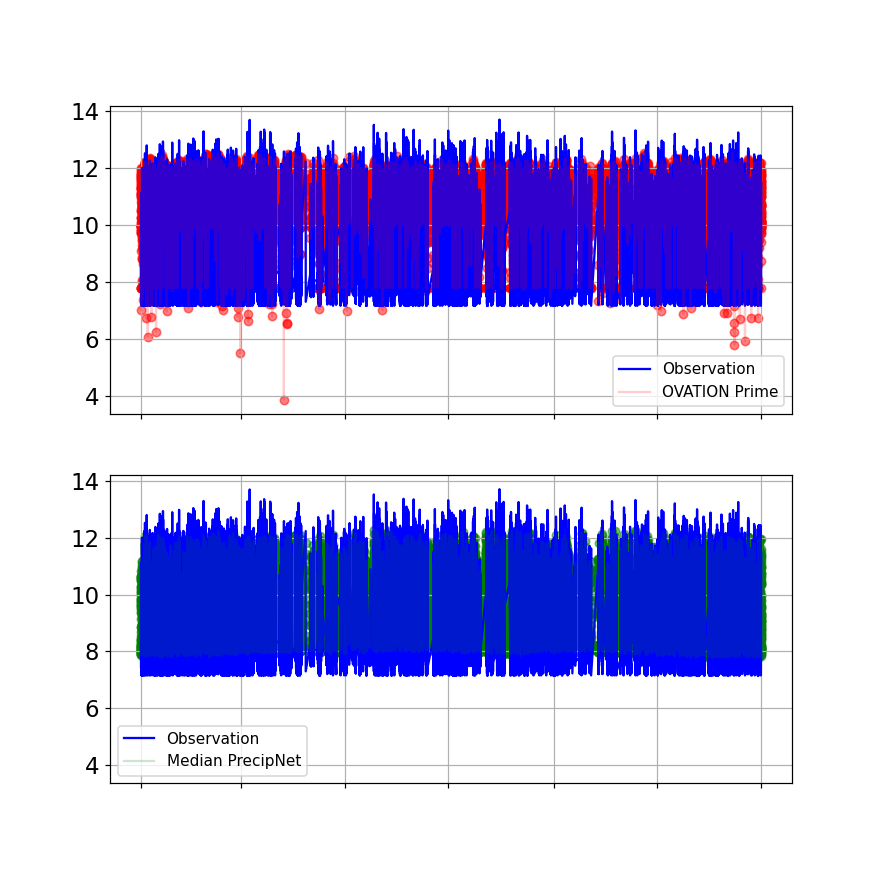

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator


(array([14610., 14669., 14730., 14791., 14853., 14914., 14975.]),
 [Text(14610.0, 0, ''),
  Text(14669.0, 0, ''),
  Text(14730.0, 0, ''),
  Text(14791.0, 0, ''),
  Text(14853.0, 0, ''),
  Text(14914.0, 0, ''),
  Text(14975.0, 0, '')])

In [39]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index,
                    y_val_log,
        #             y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )
ax_out0 = ax0.plot(y_val.index,
#                     y_val_ovation['model value'].values,
                    y_val_ovation['model value log10(ev/cm2/s)'].values,
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index,
#                     y_val_ovation['model value'],
                        y_val_ovation['model value log10(ev/cm2/s)'].values,
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index,
                    y_val_log,
        #             y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index, 
                 df_CV['minimum'].values, 
                 df_CV['maximum'].values, 
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index,
#                     y_val_ovation['model value'].values,
                    df_CV['median'].values,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index,
                      df_CV['median'].values,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




<IPython.core.display.Javascript object>


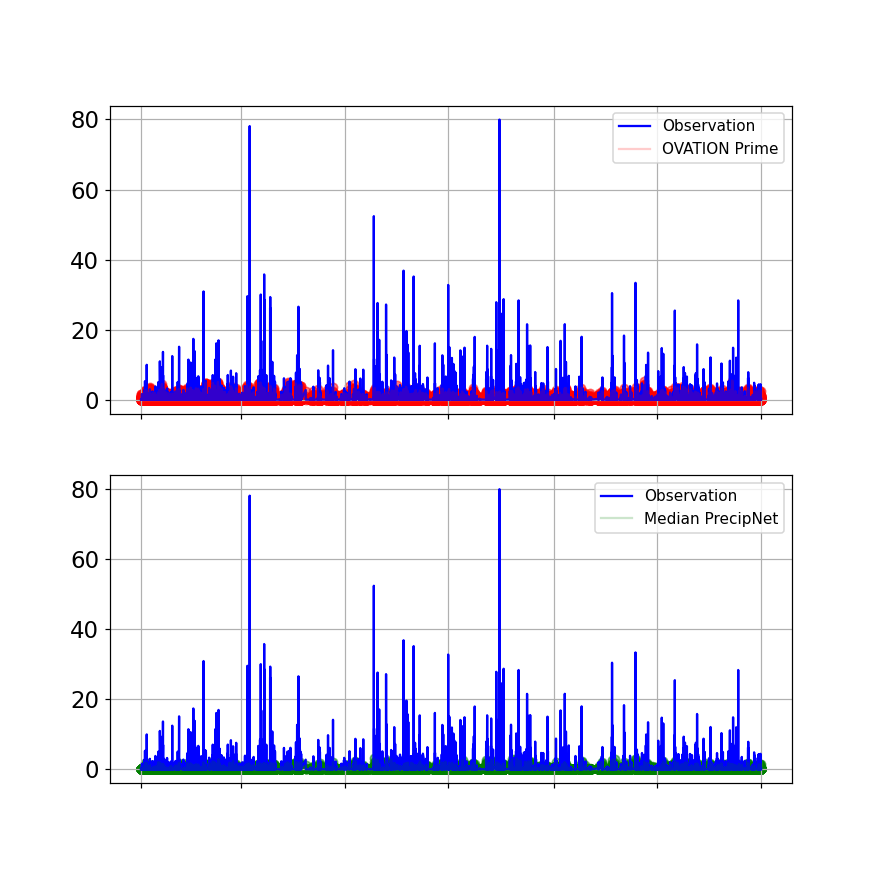

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator


(array([14610., 14669., 14730., 14791., 14853., 14914., 14975.]),
 [Text(14610.0, 0, ''),
  Text(14669.0, 0, ''),
  Text(14730.0, 0, ''),
  Text(14791.0, 0, ''),
  Text(14853.0, 0, ''),
  Text(14914.0, 0, ''),
  Text(14975.0, 0, '')])

In [38]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index,
#                     y_val_log,
                    y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )
ax_out0 = ax0.plot(y_val.index,
                    y_val_ovation['model value'].values,
#                     y_val_ovation['model value log10(ev/cm2/s)'].values,
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index,
                    y_val_ovation['model value'],
#                         y_val_ovation['model value log10(ev/cm2/s)'].values,
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index,
#                     y_val_log,
                    y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index, 
#                  df_CV['minimum'].values, 
                 10**(df_CV['minimum'].values)* erg_eV_factor,
#                  df_CV['maximum'].values, 
                 10**(df_CV['maximum'].values)* erg_eV_factor,
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index,
#                     df_CV['median'].values,
                    10**(df_CV['median'].values)* erg_eV_factor,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index,
#                       df_CV['median'].values,
                      10**(df_CV['median'].values)* erg_eV_factor,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




In [28]:
df_val_LTIMEs = df_cumulative_LTIMEs[mask_val[0]].copy(deep=True)


In [29]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

<IPython.core.display.Javascript object>


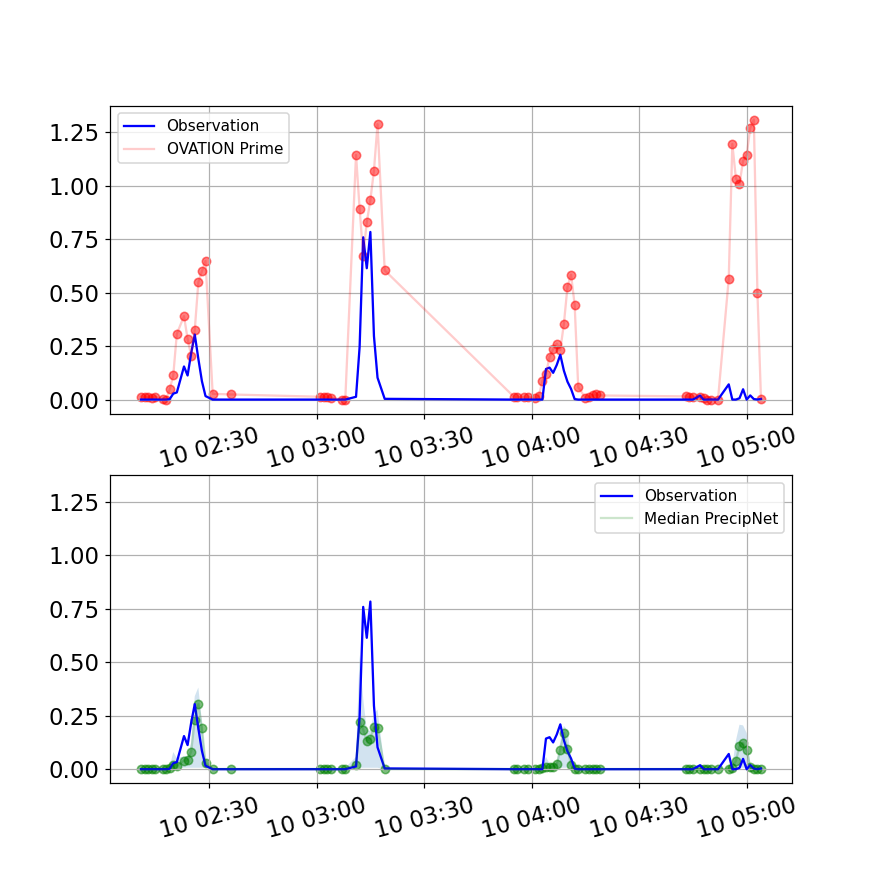

2 (74, 1)


<IPython.core.display.Javascript object>


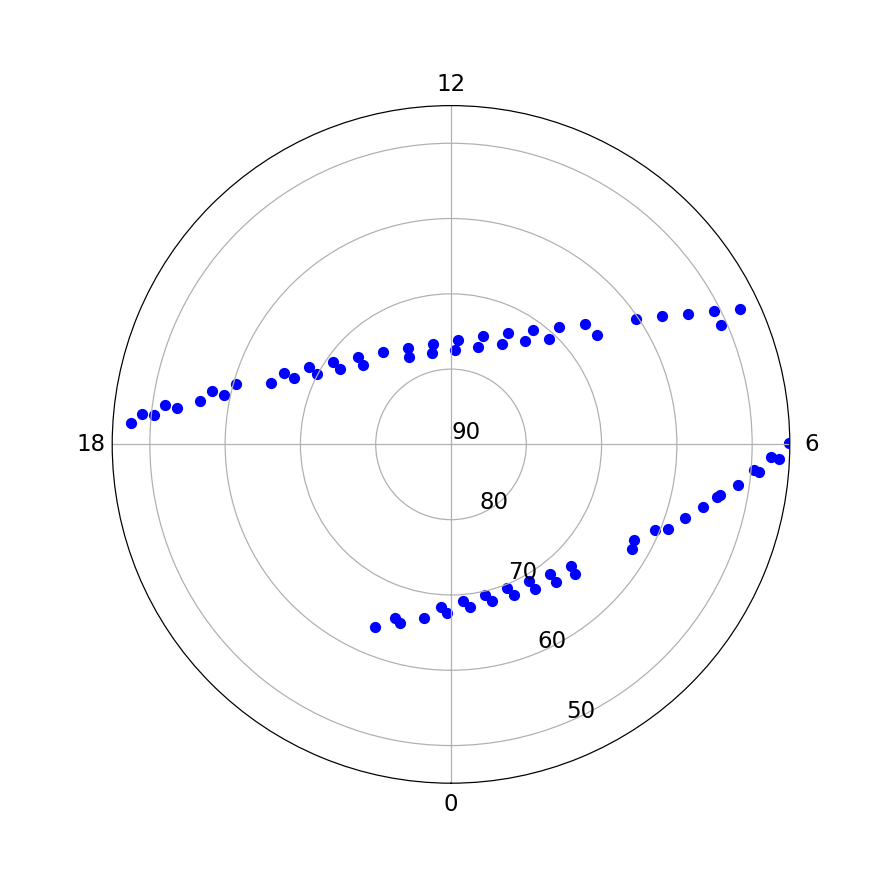

In [37]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

# %matplotlib notebook
import matplotlib.pyplot as plt
# plt.ioff()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)

datetime_range2 = [datetime.datetime(2010,12,10,1),datetime.datetime(2010,12,10,7)]
zoom_range2 = np.argwhere( (X_val.index>=datetime_range2[0]) & (X_val.index<=datetime_range2[1]) )

print(len(datetime_range2),zoom_range2.shape)
empty_string_labels = ['']*len(X_val.index)
# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_log[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_erg[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

ax_out0 = ax0.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_ovation['model value'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_ovation['model value log10(ev/cm2/s)'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_ovation['model value'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
#                         y_val_ovation['model value log10(ev/cm2/s)'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
plt.xticks(rotation=15)

# ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_log[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_erg[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]], 
                 10**(df_CV['minimum'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                 10**(df_CV['maximum'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    10**(df_CV['median'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                      10**(df_CV['median'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
# ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=15)





#----------------------------------------------------------------------------------------------------------------
# POLAR PLOT

fig = plt.figure(figsize=(8,8))
gs = GridSpec(1,1, figure=fig)
ax0 = plt.subplot(gs[0,0],polar=True)

ax_out0 = ax0.scatter(df_val_LTIMEs.values[zoom_range2[0][0]:zoom_range2[-1][0]]*15.* (np.pi/180.), 
                      90. - X_val['SC_AACGM_LAT'][zoom_range2[0][0]:zoom_range2[-1][0]],
                      s = 40,
                      c = 'b')

# define your axis limits
ax0.set_ylim([0,45])

# Set the radius labels
ax0.set_yticks(np.arange(0,50,10))  # less radial ticks
ax0.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax0.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax0.set_xticklabels(('0','6','12','18'))      

ax0.grid(True)
ax0.set_theta_zero_location("S")

#----------------------------------------------------------------------------------------------------------------


plt.show()

In [31]:
df_metrics_CV_val

df_metrics_CV_val_median = df_metrics_CV_val.median(axis=0)
df_metrics_CV_val_minimum = df_metrics_CV_val.min(axis=0)
df_metrics_CV_val_maximum = df_metrics_CV_val.max(axis=0)
df_metrics_CV_val_mean = df_metrics_CV_val.mean(axis=0)
df_metrics_CV_val_stdev = df_metrics_CV_val.std(axis=0)

for i in df_metrics_CV_val_median.index:
    if i == 'iteration':
        continue
    print('{}   {:.3F} +/- {:.2F}'.format(i,df_metrics_CV_val_median[i],df_metrics_CV_val_stdev[i]))


MAE   0.561 +/- 0.36
MSE   0.586 +/- 0.78
RMSE   0.765 +/- 0.33
RAE   0.405 +/- 0.26
RSE   0.250 +/- 0.33
RSQ   0.750 +/- 0.33
linear slope   0.716 +/- 0.31
linear intercept   2.672 +/- 2.95


In [32]:
df_metrics_CV_val

,iteration,MAE,MSE,RMSE,RAE,RSE,RSQ,linear slope,linear intercept
0,0,1.42396,2.43614,1.56081,1.02883,1.03885,-0.0388538,0,9.61907
1,1,0.559021,0.581851,0.762792,0.4039,0.248122,0.751878,0.716628,2.64863
2,2,1.42459,2.4384,1.56154,1.02928,1.03982,-0.0398174,0,9.62279
3,3,0.556632,0.581791,0.762753,0.402174,0.248096,0.751904,0.718009,2.61622
4,4,0.562073,0.586395,0.765764,0.406105,0.250059,0.749941,0.715593,2.69503
5,5,0.592996,0.613017,0.782954,0.428447,0.261412,0.738588,0.691412,2.97457
6,6,0.590876,0.618464,0.786425,0.426916,0.263735,0.736265,0.680843,2.98998
7,7,0.542871,0.573122,0.757048,0.392232,0.244399,0.755601,0.744569,2.37985
8,8,0.553713,0.584645,0.764621,0.400065,0.249313,0.750687,0.75024,2.42962
9,9,0.545757,0.578596,0.760655,0.394317,0.246734,0.753266,0.753216,2.3547


In [33]:
df_CV.columns

Index(['CV0', 'CV1', 'CV2', 'CV3', 'CV4', 'CV5', 'CV6', 'CV7', 'CV8', 'CV9',
       'median', 'minimum', 'maximum', 'stdev'],
      dtype='object')

<IPython.core.display.Javascript object>


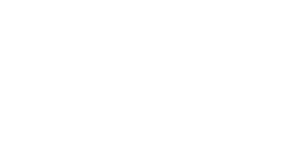

In [34]:
num_bins_plot = 100
fig = plt.figure(figsize=(10,10))
gs = GridSpec(5,2, figure=fig)
    
ctr = 0
for i in df_CV_columns:


    ax0 = fig.add_subplot(gs[ctr])
    ax0.hist(y_val_log,
             label= 'Observed validation',
             bins = num_bins_plot)
    # plt.ylabel('Validation: obs')
    plt.ylim([0,4000])
    plt.xlim([7,13])
    plt.grid(True)
    plt.xlabel('log10(eV/cm2/s)')


    ax0.hist(
             df_CV[i].values,
             bins = num_bins_plot,
             alpha = 0.7,
             color='g',
             label='NN validation prediction')

#     plt.legend()
    
    ctr +=1

<IPython.core.display.Javascript object>


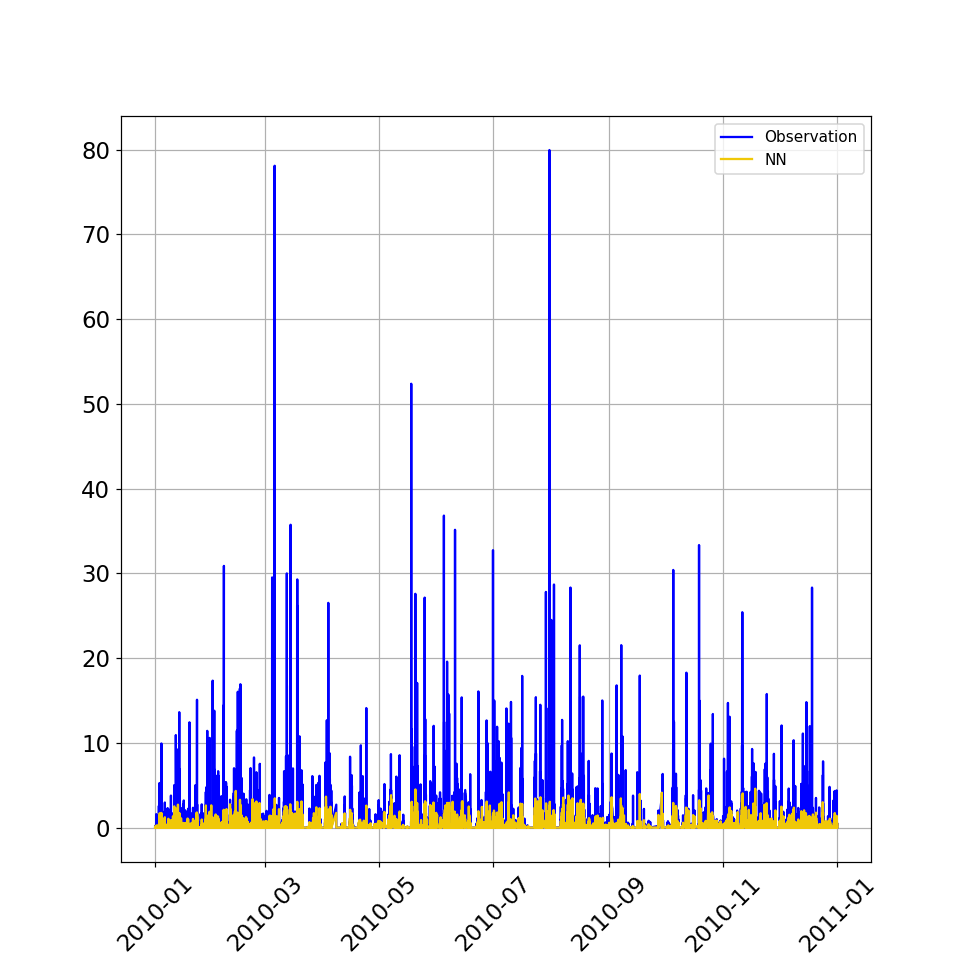

(array([14610., 14669., 14730., 14791., 14853., 14914., 14975.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [35]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(1,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(X_val.index,
#             y_val_log,
            y_val_erg,
            c = 'b',
            alpha = 1,
            label='Observation'
           )
ax_out1 = ax0.plot(X_val.index,
            10**(df_CV['CV7'].values) * (1.60218e-12),
            c = [240./255.,200./255.,8./255.,],
            alpha =1,
            label='NN'
           )

plt.grid(True)
plt.legend()
# ax2.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




<IPython.core.display.Javascript object>


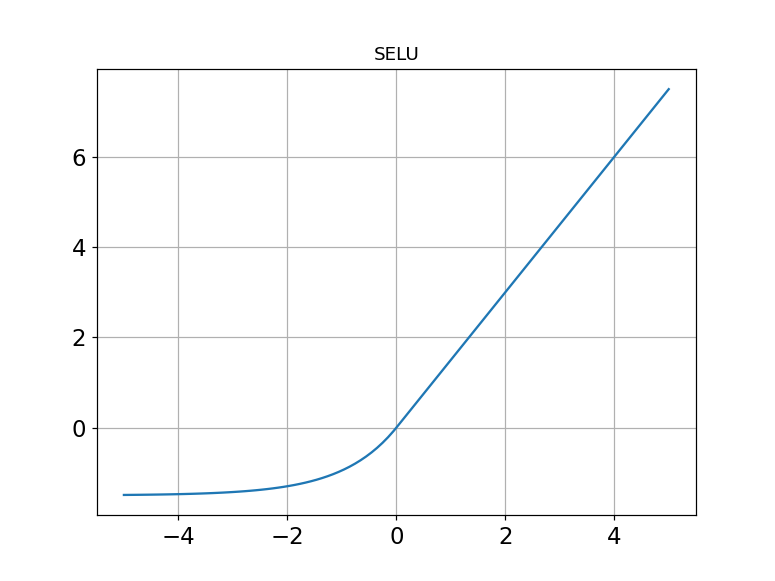

Text(0.5, 1.0, 'SELU')

In [36]:

def fun(x,lamb,alph):
    if x <= 0:
        y = lamb* ((alph)*np.exp(x) - (alph))
    elif x>0:
        y = lamb*x
    return y
    
vfun = np.vectorize(fun)
x = np.linspace(-5,5,100)
y = vfun(x,1.5,1)

plt.figure()
plt.plot(x,y)
plt.grid(True)
plt.title('SELU')
